# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb


from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


# magic word for producing visualizations in notebook
%matplotlib inline

# For displaying max number of lines
pd.set_option("display.max_rows", 500)

# For reproducability
SEED = 34

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Part 0.1:  Data Preprocessing

#### Read CSV Files

In [2]:
no_unamed = lambda x: 'Unnamed' not in x

azdias = pd.read_csv("./data/Udacity_AZDIAS_052018.csv", sep = ";" ,usecols=no_unamed)
customers = pd.read_csv("./data/Udacity_CUSTOMERS_052018.csv", sep = ";",usecols=no_unamed)
mailoutTrain = pd.read_csv("./data/Udacity_MAILOUT_052018_TRAIN.csv", sep = ";",usecols=no_unamed)
mailoutTest = pd.read_csv("./data/Udacity_MAILOUT_052018_TEST.csv", sep = ";", usecols=no_unamed)

/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_60546/317391735.py:3: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv("./data/Udacity_AZDIAS_052018.csv", sep = ";" ,usecols=no_unamed)
/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_60546/317391735.py:4: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv("./data/Udacity_CUSTOMERS_052018.csv", sep = ";",usecols=no_unamed)
/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_60546/317391735.py:5: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailoutTrain = pd.read_csv("./data/Udacity_MAILOUT_052018_TRAIN.csv", sep = ";",usecols=no_unamed)
/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_60546/317391735.py:6: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import o

#### General Look

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
mailoutTrain.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [6]:
mailoutTest.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


It is evident that all the dataframes contain a significant number of missing values. Additionally, there are extra columns present in the customers dataset.

#### Describe

In [7]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [8]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [9]:
mailoutTrain.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [10]:
mailoutTest.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42833.000000,42833.000000,35944.000000,35944.000000,2013.000000,762.000000,201.000000,39.000000,34715.000000,35206.000000,...,34530.000000,35658.000000,35658.000000,35658.000000,33214.000000,35944.000000,35206.000000,42833.000000,42833.000000,42833.000000
mean,42993.165620,0.537436,1.518890,10.239511,12.534029,13.942257,14.442786,14.410256,9.822584,6.749986,...,2.372401,4.308682,4.488474,3.090078,4.489282,8.727437,4.088280,2.800037,1.595475,3.220484
std,24755.599728,1.414777,1.737441,6.109680,3.996079,3.142155,2.787106,2.279404,4.410937,14.839779,...,1.151531,3.169149,3.274829,2.510134,1.886903,1.013702,2.053977,1.120624,0.490806,1.069753
min,2.000000,-1.000000,1.000000,0.000000,2.000000,4.000000,6.000000,9.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,21650.000000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,2.000000,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,1.000000,3.000000
50%,43054.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,14.000000,10.000000,2.000000,...,2.000000,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,2.000000,4.000000
75%,64352.000000,2.000000,1.000000,15.000000,16.000000,17.000000,17.000000,16.000000,13.000000,7.000000,...,3.000000,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,2.000000,4.000000
max,85794.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,379.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


#### Info

In [11]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [13]:
mailoutTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [14]:
mailoutTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


#### Shape

In [15]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [16]:
print("Azdias shape -",azdias.shape)
print("Customers shape -",customers.shape)
print("Mailout Train shape -",mailoutTrain.shape)
print("Mailout Testshape -",mailoutTest.shape)

Azdias shape - (891221, 366)
Customers shape - (191652, 369)
Mailout Train shape - (42962, 367)
Mailout Testshape - (42833, 366)


In [17]:
extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [18]:
customers[extra_cols_in_customers].head()


,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


These three columns provide detailed insights into the customers and their purchasing behavior. Additionally, there are two supplementary dataframes containing attribute details, which explain the meaning of each column.

##### Azdias

#### Correlation

Correlation of azdias

In [19]:
import numpy as np
import pandas as pd

correlation_threshold = 0.85

numerical_columns = azdias.select_dtypes(include=['float64', 'int64'])

corr_matrix = numerical_columns.corr()

high_corr_pairs = np.where(np.abs(corr_matrix) > correlation_threshold)

high_corr_list = []

for i in range(len(high_corr_pairs[0])):
    if high_corr_pairs[0][i] != high_corr_pairs[1][i]:  # Skip diagonal elements
        col1 = corr_matrix.columns[high_corr_pairs[0][i]]
        col2 = corr_matrix.columns[high_corr_pairs[1][i]]
        correlation_value = corr_matrix.iloc[high_corr_pairs[0][i], high_corr_pairs[1][i]]
        high_corr_list.append((col1, col2, correlation_value))

high_corr_df = pd.DataFrame(high_corr_list, columns=['Feature 1', 'Feature 2', 'Correlation'])

high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

print("Highly Correlated Features (Correlation > 0.85):")
print(high_corr_df)


Highly Correlated Features (Correlation > 0.85):
                       Feature 1                    Feature 2  Correlation
75             KBA13_HERST_SONST           KBA13_FAB_SONSTIGE     1.000000
69            KBA13_FAB_SONSTIGE            KBA13_HERST_SONST     1.000000
94           LP_LEBENSPHASE_GROB          LP_LEBENSPHASE_FEIN     0.989961
91           LP_LEBENSPHASE_FEIN          LP_LEBENSPHASE_GROB     0.989961
86               LP_FAMILIE_GROB              LP_FAMILIE_FEIN     0.984100
83               LP_FAMILIE_FEIN              LP_FAMILIE_GROB     0.984100
95                LP_STATUS_FEIN               LP_STATUS_GROB     0.982411
96                LP_STATUS_GROB               LP_STATUS_FEIN     0.982411
70                     KBA13_GBZ                     PLZ8_GBZ     0.979854
102                     PLZ8_GBZ                    KBA13_GBZ     0.979854
0            ANZ_HAUSHALTE_AKTIV   ANZ_STATISTISCHE_HAUSHALTE     0.976900
1     ANZ_STATISTISCHE_HAUSHALTE          ANZ_HAUSH

Mean values of first 30 columns

In [30]:
top_30_columns = azdias.count().sort_values(ascending=False).head(30).index[1:]

column_means = azdias[top_30_columns].mean()

In [31]:
column_means

D19_VERSAND_ANZ_24           0.958868
FINANZ_ANLEGER               3.033328
D19_WEIN_FEINKOST            0.377515
D19_VOLLSORTIMENT            1.728497
D19_VERSICHERUNGEN           1.259786
D19_VERSI_ONLINE_DATUM       9.976712
D19_VERSI_OFFLINE_DATUM      9.922649
D19_VERSI_DATUM              9.142563
D19_VERSI_ANZ_24             0.206998
D19_VERSI_ANZ_12             0.113597
D19_VERSAND_REST             0.829550
D19_VERSAND_ONLINE_DATUM     7.942473
D19_VERSAND_OFFLINE_DATUM    9.326818
D19_VERSAND_DATUM            7.717380
D19_VERSAND_ANZ_12           0.604646
D19_NAHRUNGSERGAENZUNG       0.244524
D19_TIERARTIKEL              0.243178
D19_TELKO_REST               0.779996
D19_TELKO_ONLINE_DATUM       9.981780
D19_TELKO_OFFLINE_DATUM      9.828039
D19_TELKO_MOBILE             1.009937
D19_TELKO_DATUM              9.428728
D19_TELKO_ANZ_24             0.098804
D19_TELKO_ANZ_12             0.049056
D19_TECHNIK                  1.738563
D19_SONSTIGE                 2.365959
D19_SCHUHE  

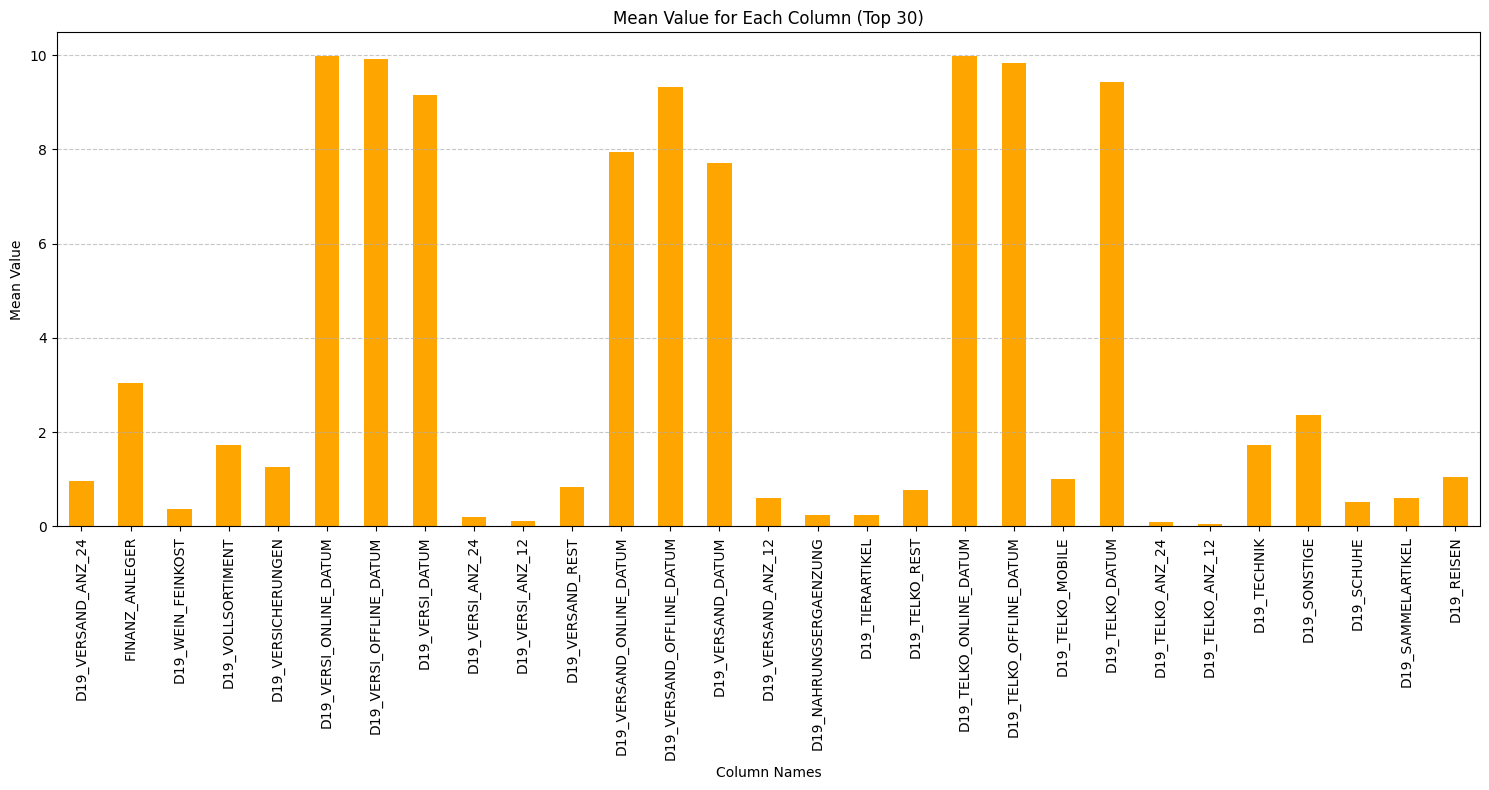

In [32]:
plt.figure(figsize=(15, 8))
column_means.plot(kind='bar', color='orange')
plt.title('Mean Value for Each Column (Top 30)')
plt.xlabel('Column Names')
plt.ylabel('Mean Value')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Distribution first 5 columns

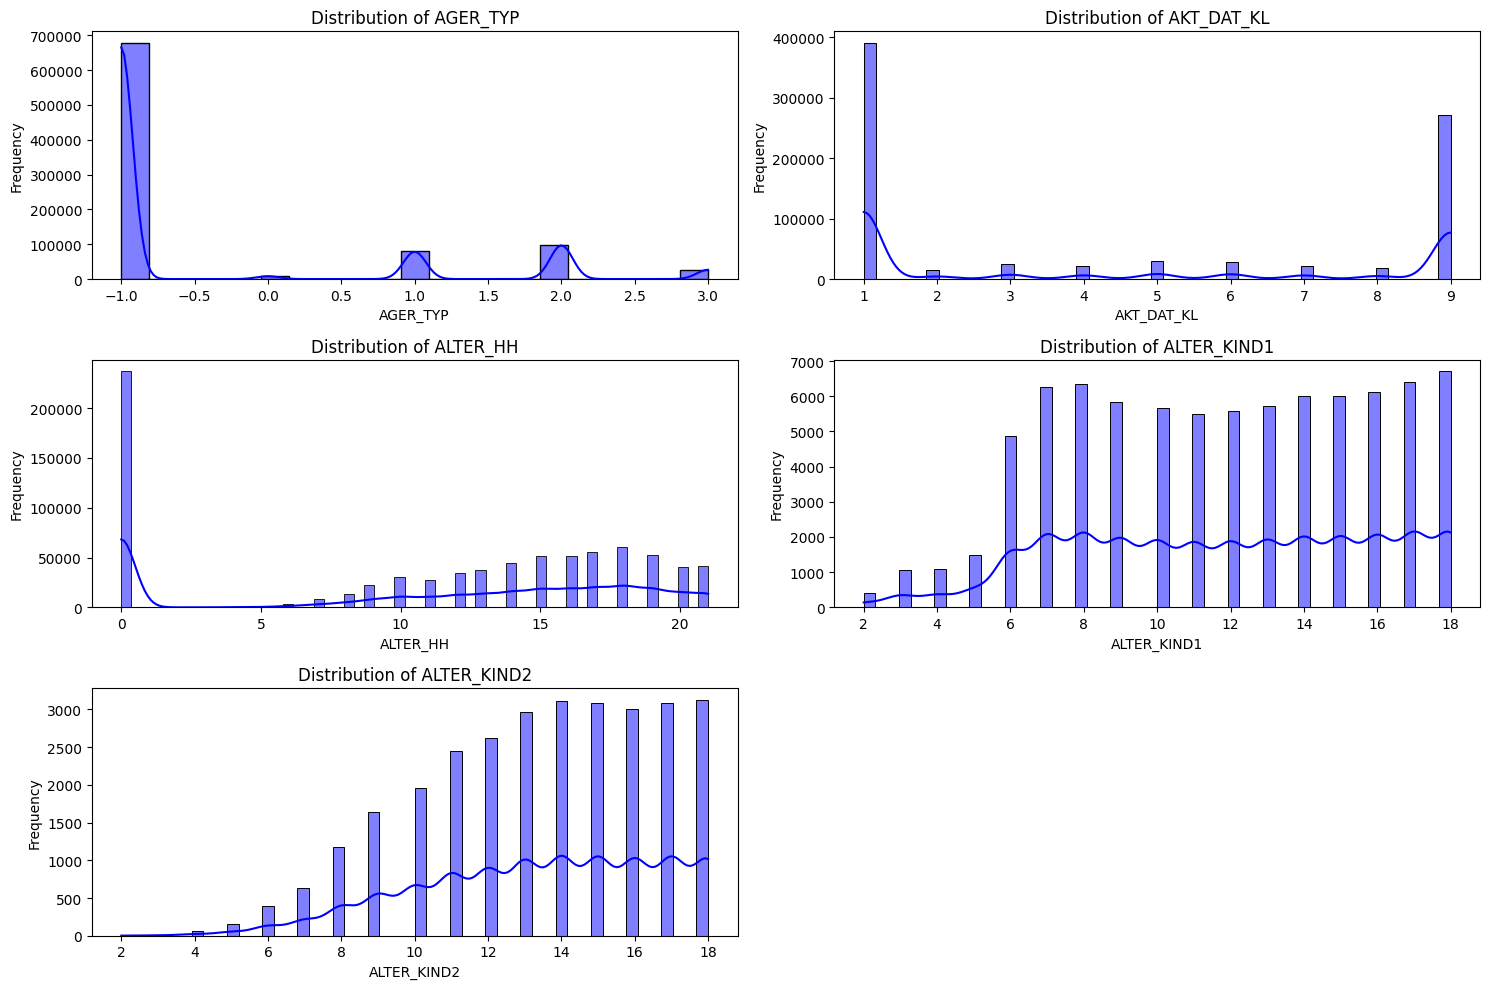

In [35]:
numerical_columns = azdias.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns[1:6], 1):
    plt.subplot(3, 2, i)
    sns.histplot(azdias[col].dropna(), kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##### Customers

In [38]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [39]:
import numpy as np
import pandas as pd

correlation_threshold = 0.85

numerical_columns = customers.select_dtypes(include=['float64', 'int64'])

corr_matrix = numerical_columns.corr()

high_corr_pairs = np.where(np.abs(corr_matrix) > correlation_threshold)

high_corr_list = []

for i in range(len(high_corr_pairs[0])):
    if high_corr_pairs[0][i] != high_corr_pairs[1][i]:  # Skip diagonal elements
        col1 = corr_matrix.columns[high_corr_pairs[0][i]]
        col2 = corr_matrix.columns[high_corr_pairs[1][i]]
        correlation_value = corr_matrix.iloc[high_corr_pairs[0][i], high_corr_pairs[1][i]]
        high_corr_list.append((col1, col2, correlation_value))

high_corr_df = pd.DataFrame(high_corr_list, columns=['Feature 1', 'Feature 2', 'Correlation'])

high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

print("Highly Correlated Features (Correlation > 0.85):")
print(high_corr_df)


Highly Correlated Features (Correlation > 0.85):
                       Feature 1                    Feature 2  Correlation
68             KBA13_HERST_SONST           KBA13_FAB_SONSTIGE     1.000000
63            KBA13_FAB_SONSTIGE            KBA13_HERST_SONST     1.000000
87           LP_LEBENSPHASE_GROB          LP_LEBENSPHASE_FEIN     0.993811
84           LP_LEBENSPHASE_FEIN          LP_LEBENSPHASE_GROB     0.993811
2            ANZ_HAUSHALTE_AKTIV   ANZ_STATISTISCHE_HAUSHALTE     0.990112
3     ANZ_STATISTISCHE_HAUSHALTE          ANZ_HAUSHALTE_AKTIV     0.990112
86           LP_LEBENSPHASE_GROB              LP_FAMILIE_GROB     0.988214
81               LP_FAMILIE_GROB          LP_LEBENSPHASE_GROB     0.988214
76               LP_FAMILIE_FEIN              LP_FAMILIE_GROB     0.982096
79               LP_FAMILIE_GROB              LP_FAMILIE_FEIN     0.982096
80               LP_FAMILIE_GROB          LP_LEBENSPHASE_FEIN     0.979804
83           LP_LEBENSPHASE_FEIN              LP_FA

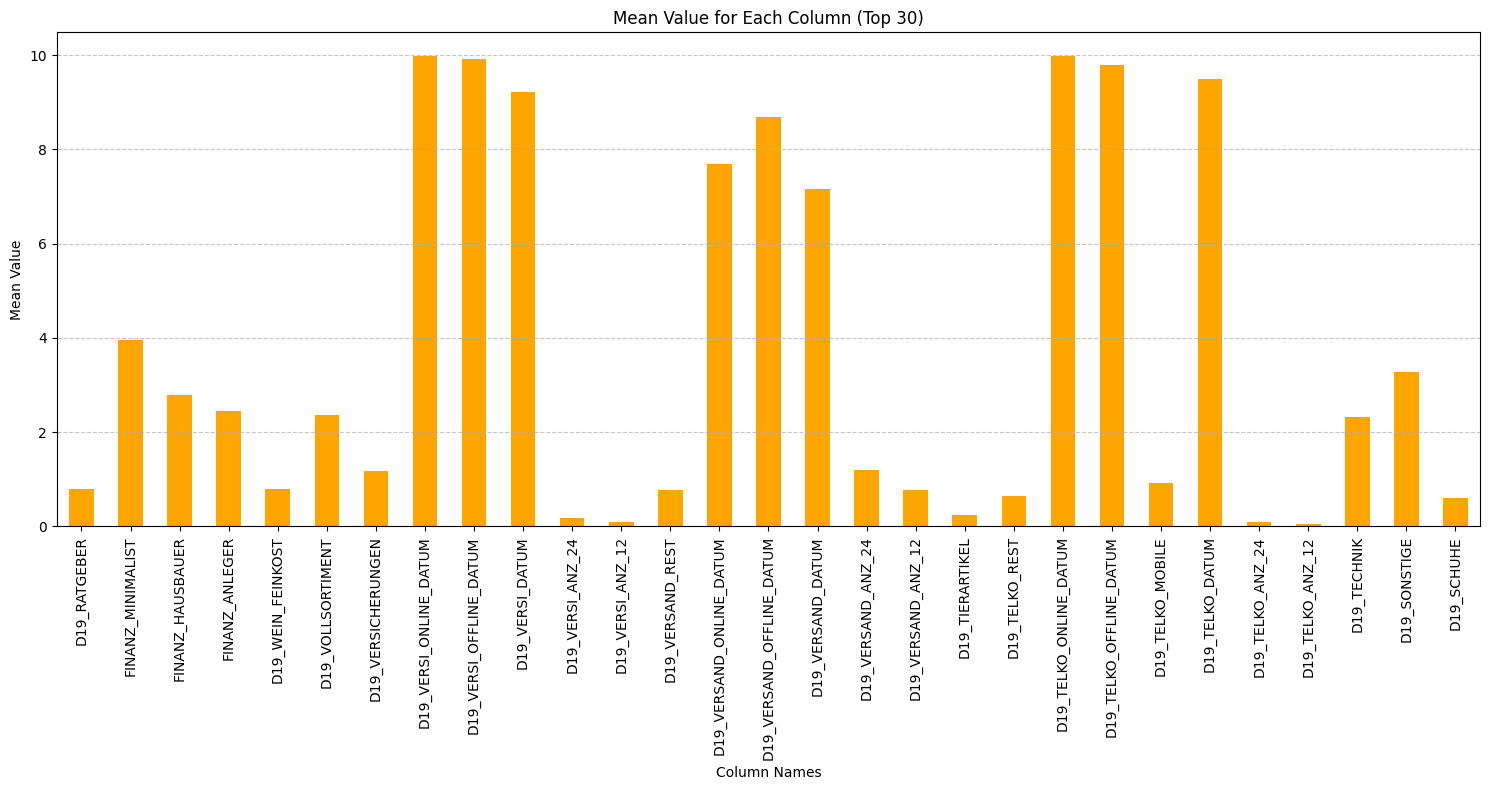

In [40]:
top_30_columns = customers.count().sort_values(ascending=False).head(30).index[1:]
column_means = customers[top_30_columns].mean()

plt.figure(figsize=(15, 8))
column_means.plot(kind='bar', color='orange')
plt.title('Mean Value for Each Column (Top 30)')
plt.xlabel('Column Names')
plt.ylabel('Mean Value')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


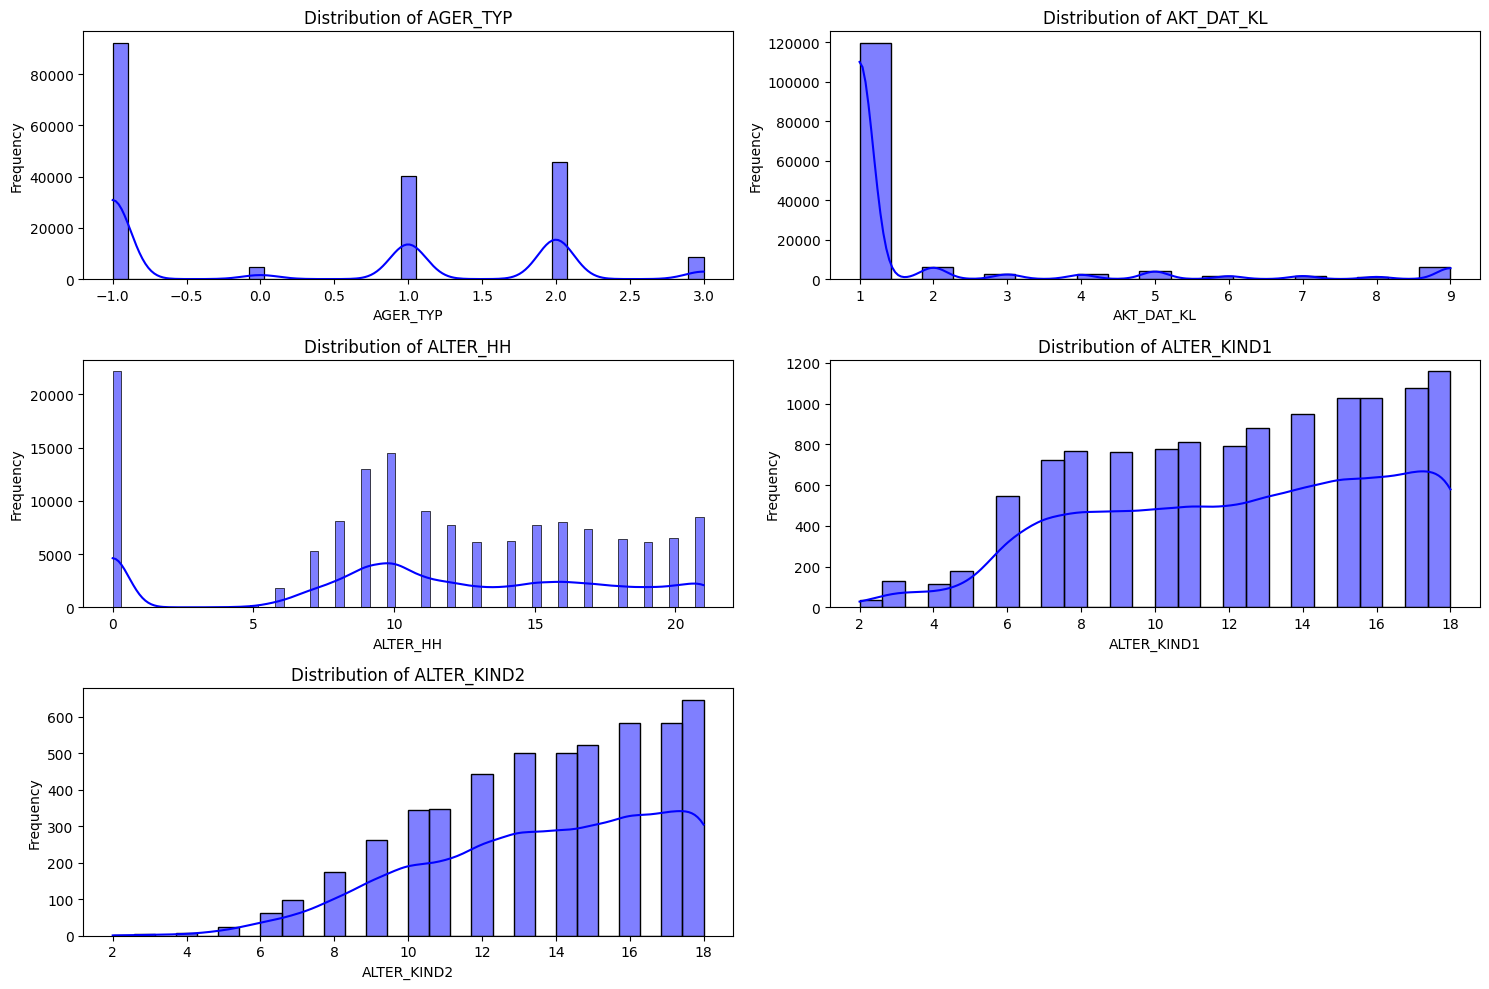

In [41]:
numerical_columns = customers.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns[1:6], 1):
    plt.subplot(3, 2, i)
    sns.histplot(customers[col].dropna(), kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Look through attributes and information levels

In [18]:
no_unamed = lambda x: 'Unnamed' not in x

diasAttr = pd.read_excel("./data/DIAS Attributes - Values 2017.xlsx", engine= "openpyxl", header = 1,usecols= no_unamed)
diasIL = pd.read_excel("./data/DIAS Information Levels - Attributes 2017.xlsx", engine= "openpyxl", header = 1,usecols= no_unamed)

In [388]:
diasAttr.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [389]:
diasAttr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    2258 non-null   object
 1   Description  351 non-null    object
 2   Value        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB


In [390]:
diasIL.head(15)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combin..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [391]:
diasIL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  10 non-null     object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB


As mentioned earlier, each attribute includes multiple rows corresponding to the different values it can have. We can utilize the ffill() method in pandas to fill the NaN values in the Attribute column, allowing us to efficiently access all the information related to an attribute at once.

In [83]:
diasAttr["Attribute"] = diasAttr["Attribute"].ffill()


In [84]:
diasAttr.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


### Part 0.1.2: Warning Finding

Additionally, we should examine the data types of columns 18 and 19, as a warning was triggered during the data loading process. This will help identify any potential issues with these columns.

In [85]:
print(azdias.columns[18:20])

warning_cols = list(azdias.columns[18:20])

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015'], dtype='object')


In [86]:
diasAttr[diasAttr["Attribute"] == "CAMEO_DEUG_2015"]


,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


In [87]:
diasAttr[diasAttr["Attribute"] == "CAMEO_DEUINTL_2015"]


,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,NaN,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,NaN,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,NaN,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,NaN,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
112,CAMEO_DEUINTL_2015,NaN,22,Prosperous Households-Young Couples With Children
113,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
114,CAMEO_DEUINTL_2015,NaN,24,Prosperous Households-Older Families & Mature ...


Based on the examination of the two dataframes, we can infer that these two columns should contain values within the range specified in the "Value" column—where -1 indicates unknown values and integers represent the respective categories. To verify this, we can inspect the actual values in these columns by printing their unique values.

In [88]:
azdias[warning_cols].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEU_2015   792242 non-null  object
 1   CAMEO_DEUG_2015  792242 non-null  object
dtypes: object(2)
memory usage: 13.6+ MB


In [92]:
print(azdias[warning_cols[0]].unique())
print(azdias[warning_cols[1]].unique())
print(customers[warning_cols[0]].unique())
print(customers[warning_cols[1]].unique())

[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D' 'XX']
[1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']


We found that the columns contain unexpected values such as 'X' and 'XX', which are not mentioned in the description, along with 'nan' values. To handle this, we can replace these values with np.nan, as the attribute dataframe indicates that unknown values can be treated as '-1'. For simplicity, we will interpret '-1' as np.nan. Additionally, there is inconsistency in the data types, with some values being strings and others as floats. We should standardize them by converting all values to integers.

In [174]:
def fix_cameo_cols(df):
    """
    Function to replace 'X', 'XX' and 'nan' values with -1 in 
    columns 18 and 19 i.e. ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] 
    
    Also "CAMEO_DEU_2015", but it is dropped in later steps.
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan}, regex=False)
    df[cols] = df[cols].astype(float)
    
    return df

In [94]:
customers = fix_cameo_cols(customers)
azdias = fix_cameo_cols(azdias)

In [96]:
print(azdias[warning_cols[1]].unique(), customers[warning_cols[1]].unique())
print(azdias.shape, customers.shape)


[nan  8.  4.  2.  6.  1.  9.  5.  7.  3.] [ 1. nan  5.  4.  7.  3.  9.  2.  6.  8.]
(891221, 367) (191652, 370)


### Part 0.1.3: Exploring DIAS Attributes

In [392]:
diasAttr.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


The attribute information includes:

- **Attribute**: The name of the column.
- **Description**: A brief explanation of what the column represents.
- **Value**: The range of values recorded during data collection.
- **Meaning**: The definition or significance of each corresponding value.

To clean the dataset effectively, we should review all attributes, their descriptions, and the values recorded for unknown observations. This will allow us to systematically replace unknown values with `np.nan`, similar to the approach we took with columns 18 and 19. This step will ensure consistency and improve the quality of our data.

In [98]:
diasAttr.dropna()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [99]:
diasAttr_list  = diasAttr.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

In [100]:
common_to_all = (set(diasAttr_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(diasAttr_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(diasAttr_list) - set(azdias_list))
unique_to_attributes = (set(diasAttr_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(diasAttr_list) - set(azdias_list))
unique_to_azdias_vs_attributes = (set(diasAttr_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(diasAttr_list))

print("No of columns common to all 3 daframes: ", str(len(common_to_all)))
print("No of columns specific to azdias: " + str(len(unique_to_azdias)))
print("No of columns specific to customers: " + str(len(unique_to_customers)))
print("No of columns specific to attributes: " + str(len(unique_to_attributes)))
print("No of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("No of columns exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of columns common to all 3 daframes:  272
No of columns specific to azdias: 0
No of columns specific to customers: 3
No of columns specific to attributes: 42
No of columns common between azdias and attributes: 272
No of columns exclusive to attributes vs azdias: 42
No of columns exclusive to azdias vs attributes: 42


There are 42 unique columns listed in the attribute-values data that are absent in both the azdias and customer datasets. This discrepancy could be due to recording errors or inconsistencies in data collection. While it is possible to investigate and address the reasons for these missing columns, for this analysis, we will focus only on the 272 columns that are common across all three dataframes. We will proceed by replacing the 'unknown' values within these shared columns to maintain consistency.

### Part 0.1.4: Data Cleaning & Feature Engineering

In [101]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_STATUS_FEIN.unique())

[ 2.  5.  1.  0. 10.  7. 11.  3.  8.  4.  6. nan  9.]
[ 2.  3.  1.  0.  5.  4. nan]
[ 1.  2.  4.  5.  3. nan]
[ 4.  6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  8. nan]
[15. 21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. nan 40. 16. 17.]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]


The columns `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`, and `LP_LEBENSPHASE_GROB` contain entries with the value `0`, which, according to the provided values information in the *DIAS Attributes - Values 2017.xlsx*, do not correspond to any valid category. Therefore, any occurrence of `0` in these columns will be replaced with `NaN`.

Additionally, there is an opportunity to simplify the information within these columns. This can be achieved using the following approach:

- The columns `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` provide detailed classifications of family type and status, while the broader classifications are given by `LP_FAMILIE_GROB` and `LP_STATUS_GROB`. To avoid redundancy, only the broader categorization (`LP_FAMILIE_GROB` and `LP_STATUS_GROB`) will be retained, and the finer-grained columns (`LP_FAMILIE_FEIN` and `LP_STATUS_FEIN`) will be dropped later when we streamline all the unnecessary columns.

- The column `LP_LEBENSPHASE_GROB` offers a general description of a person’s life stage with respect to age and wealth, whereas `LP_LEBENSPHASE_FEIN` provides a more detailed classification of the same information. Therefore, these two columns can be restructured, where one column will capture age-related information, and the other will focus on wealth-related information.

This restructuring and consolidation of columns will help reduce redundancy and streamline the dataset for analysis.

In [102]:
def fix_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [103]:
azdias = fix_LP_cols(azdias)
customers = fix_LP_cols(customers)

In [104]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_STATUS_FEIN.unique())

[ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
[ 1.  2.  0. nan]
[ 0.  1. nan]
[ 1.  2. nan  3.  4.]
[ 3.  2.  1. nan  4.]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]


In [105]:
def fix_eigefugt_col(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [106]:
azdias = fix_eigefugt_col(azdias)
customers = fix_eigefugt_col(customers)

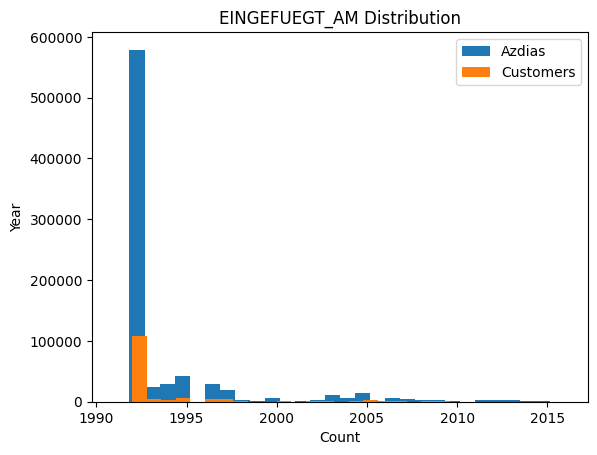

In [107]:
plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias")
plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers")
plt.ylabel("Year")
plt.xlabel("Count")
plt.title("EINGEFUEGT_AM Distribution")
plt.legend()
plt.show()


It appears that the distributions across the categorical columns are quite similar. Additionally, the analysis indicates that individuals who registered before 1995 have a higher likelihood of being customers based on the provided graph.

Moving forward, our next steps will involve:

Replacing Unknown Values with NaNs: We'll ensure that all unknown or unspecified values in the categorical columns are replaced with NaN. This will help maintain consistency in handling missing or undefined values across the dataframe.

Further Analysis and Transformation of Categorical Columns: Once the unknown values are handled, we can continue by analyzing other categorical columns for potential restructuring or transformation. This may include consolidating similar categories, reclassifying values based on certain criteria, or dropping redundant columns to simplify the analysis.

#### Addressing Unknown Values

In [108]:
unkown_attributes_values = diasAttr[diasAttr["Meaning"] == "unknown"]
print(len(unkown_attributes_values))

232


In [110]:
unkown_attributes_values.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown


In [112]:
def get_unkown_repr(attrib, unkown_attributes_values):
    """Returns the representation of unkown values"""
    
    unkown = unkown_attributes_values[unkown_attributes_values["Attribute"] == attrib]["Value"]
    unkown = unkown.astype(str).str.cat(sep=",")
    unkown = [int(x) for x in unkown.split(",")]
      
    return [unkown]

In [113]:
ager_typ_unkwon = get_unkown_repr("AGER_TYP", unkown_attributes_values)

print(ager_typ_unkwon)


[[-1]]


In [114]:
azdias.head(15)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,15.0
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,21.0
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,3.0
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,NaN
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,32.0
5,5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,8.0
6,6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,...,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2,2.0
7,7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,...,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1,5.0
8,8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,...,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3,10.0
9,9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,...,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3,4.0


In [115]:
def replace_unkown_with_nan(val, unkown):
    """Replaces unkown values with np.nan values if the value mathes with the unkown representation"""
    if val in unkown:
        return np.nan
    else:
        return val

In [116]:
azdias["AGER_TYP"] = azdias["AGER_TYP"].apply(replace_unkown_with_nan, args=(ager_typ_unkwon))


In [118]:
azdias.head(15)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp
0,0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,15.0
1,1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,21.0
2,2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,3.0
3,3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,NaN
4,4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,32.0
5,5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,8.0
6,6,910248,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,...,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2,2.0
7,7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,...,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1,5.0
8,8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,...,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3,10.0
9,9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,...,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3,4.0


In [119]:
def replace_unkowns(df, unkown_attributes_values, verbose=False):
    """
    Replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list.
    """
    for attrib in unkown_attributes_values.Attribute:
        unkown = get_unkown_repr(attrib, unkown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unkown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
    return df

In [120]:
azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

In [121]:
customers = replace_unkowns(customers, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

#### Missing Values

With all unknowns now replaced by np.nan, we can examine the number of missing values in each column and determine whether each column should be retained for further analysis

##### In Column-Wise

In [122]:
def get_missing_report(df):
    """
    Takes in a dataframe and returns a dataframe with information about column-wise missing values percentages.
    """
    missing_percen = df.isna().sum() * 100/ len(df)
    
    missing_percen_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    return missing_percen_df

In [123]:
customer_missing_report = get_missing_report(customers)
azdias_missing_report = get_missing_report(azdias)

In [124]:
print("Total No of columns in Customers - ", len(customers.columns))
print("No of columns with missing values in customers - ",
      len(customer_missing_report[customer_missing_report.Missing_Percentage > 0]))

print("Total No of columns in Azdias - ", len(azdias.columns))
print("No of columns with missing values in azdias - ",
      len(azdias_missing_report[azdias_missing_report.Missing_Percentage > 0]))

Total No of columns in Customers -  371
No of columns with missing values in customers -  280
Total No of columns in Azdias -  368
No of columns with missing values in azdias -  280


In [125]:
def plot_percentage_missing(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    # fig.tight_layout()
    plt.show()

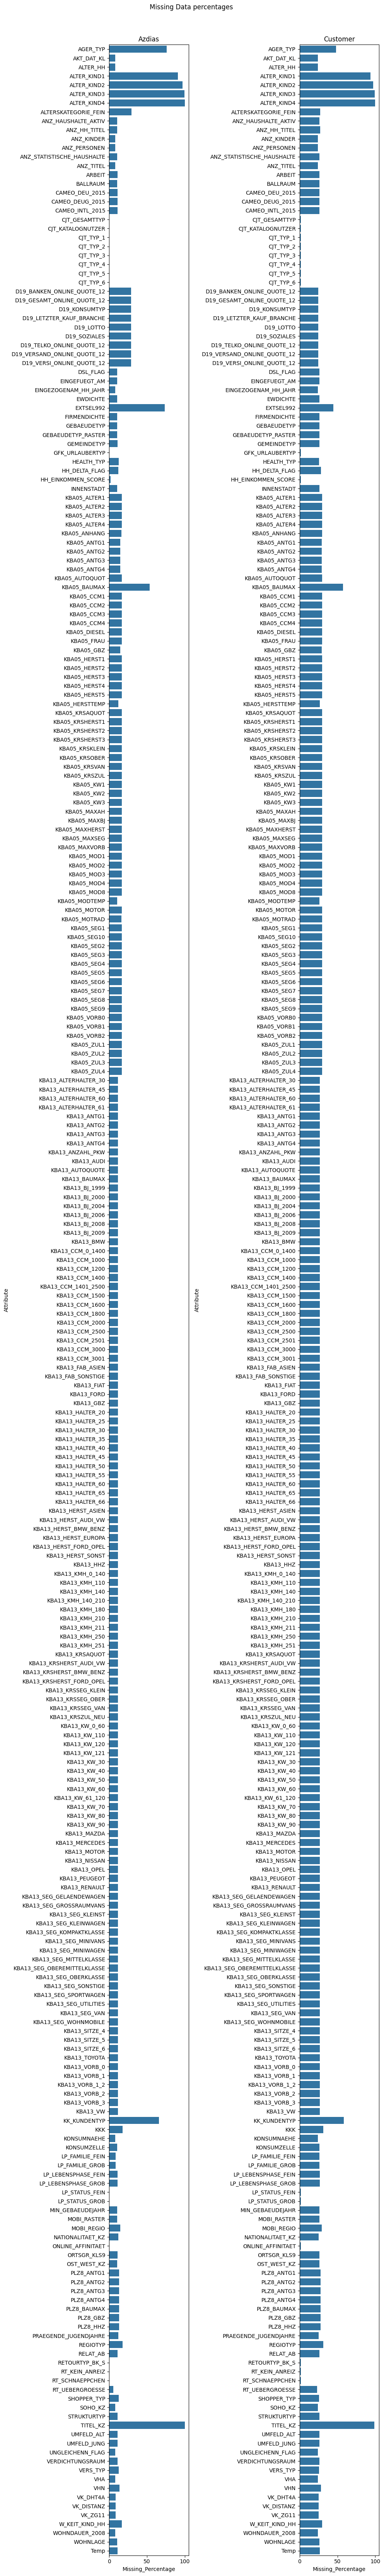

In [126]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=0)

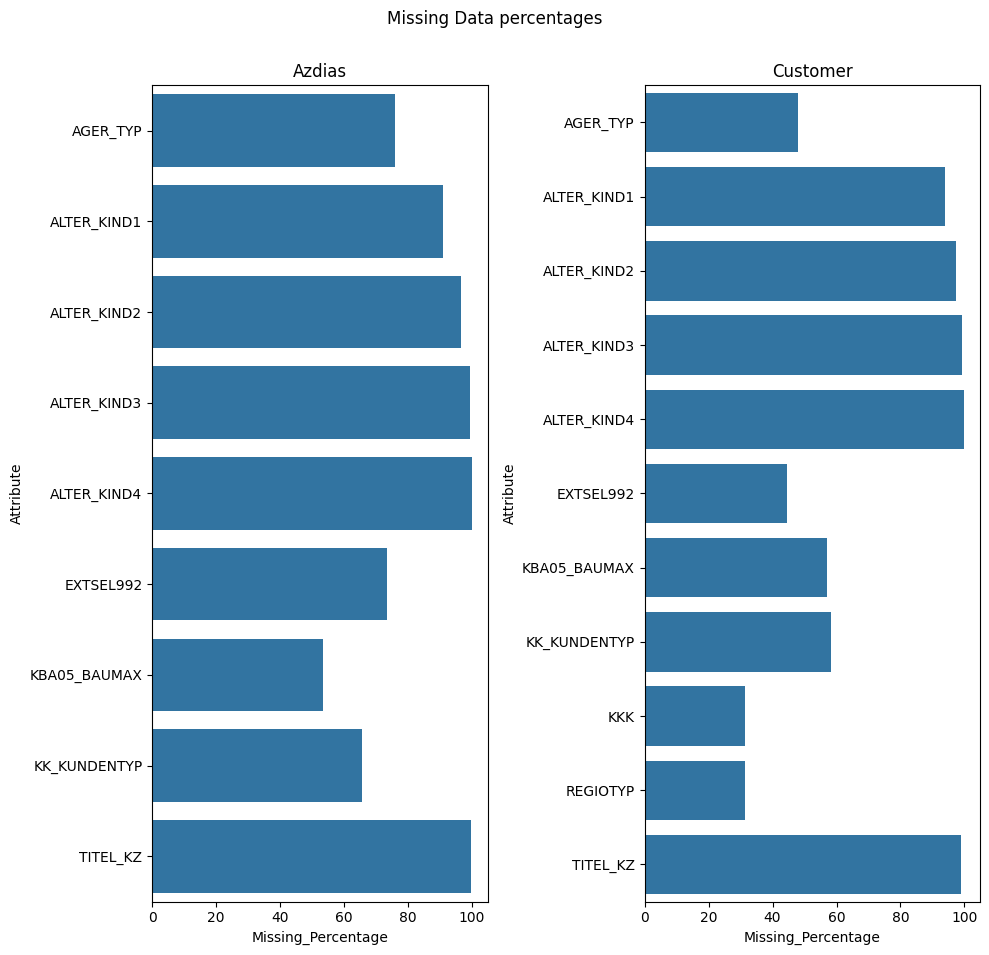

In [127]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=30, figsize=(10, 10))

We identified 11 features in the Customer data that have over 30% missing values, while in the Azdias data, there are only 9 features with a similar level of missing data. In total, there are 279 columns with missing values across both datasets. Compared to the total count of 279, these 11 and 9 features represent a significantly smaller proportion, making them suitable for removal. We will proceed by dropping the features with over 30% missing data from the Customer dataset and apply the same removal to the Azdias dataset to maintain consistency.

In [128]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
         
    df1 = remove_columns(df1, remove_cols)
    df2 = remove_columns(df2, remove_cols)
    print(f"\t\tRemoved {len(remove_cols)} columns from given dataframes")
    
    return (df1, df2, remove_cols)

In [129]:
print("Number of columns Before dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

azdias, customers, removed_cols = remove_missing_columns(azdias, customers, customer_missing_report, azdias_missing_report)

print("Number of columns After dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns Before dropping
Azdias - 368
Customers - 371
		Removed 11 columns from given dataframes
Number of columns After dropping
Azdias - 357
Customers - 360


##### In Row-Wise

In [135]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.histplot(df1.isnull().sum(axis=1), bins=bins, kde=False, ax=ax, label="Azdias")
    sns.histplot(df2.isnull().sum(axis=1), bins=bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

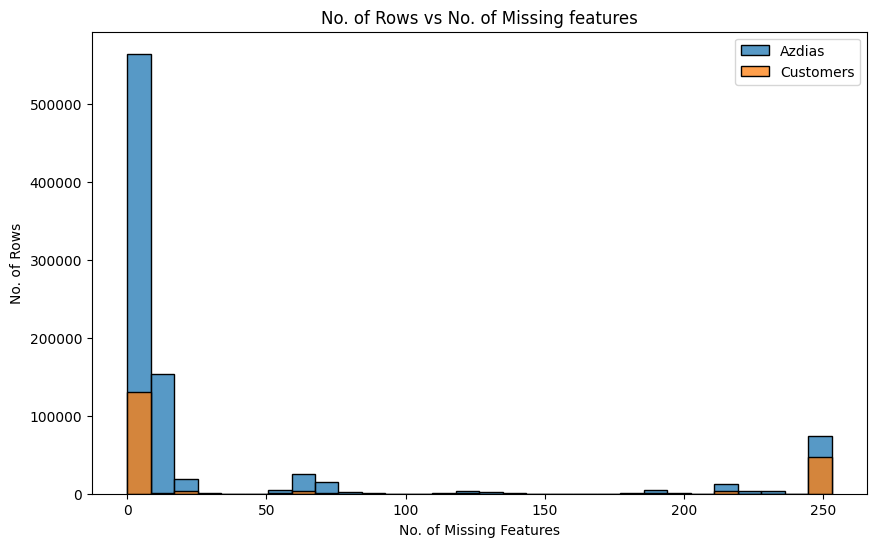

In [136]:
plot_missing_rowwise_histogram(azdias, customers)

Based on the plot, we can conclude the following:

Out of the total 355 features, around 250 features exhibit missing values in approximately 70,000 rows in the Azdias dataset and around 50,000 rows in the Customers dataset.
In both datasets, the majority of rows have fewer than 50 missing values.
The Customers dataset contains comparatively more rows with missing values than the Azdias dataset.
Given this, we can proceed by removing all rows with more than 50 missing values to improve data quality.

In [137]:
def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [138]:
print("Number of rows Before dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print("Number of rows After dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

Number of rows Before dropping
Azdias - 891221
Customers - 191652
		Removed 57406 rows from  dataframe
		Removed 153933 rows from  dataframe
Number of rows After dropping
Azdias - 737288
Customers - 134246


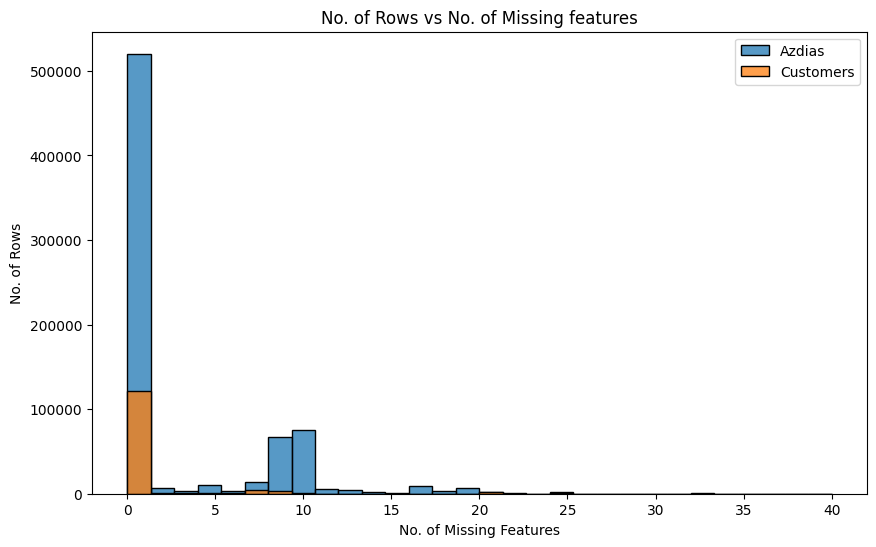

In [139]:
plot_missing_rowwise_histogram(azdias, customers)

As observed from the plot, we have successfully eliminated all rows with more than 50 missing features. However, there are still some missing values ranging between 1 and 50 per row. Given that the dataset represents the demographics of a population, we can make the assumption that the missing values are likely to match the most common values within their respective features. Therefore, we can proceed by imputing the missing values with the most frequent values of the corresponding features to maintain the integrity of the demographic information.

##### Column Types

In [140]:
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]
customer_object_cols = customers.columns[customers.dtypes == "object"]

In [141]:
print("Azdias columns with dtype Object \n",azdias_object_cols.values)
print("Azdias columns with dtype Object \n",customer_object_cols.values)

Azdias columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']
Azdias columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ' 'PRODUCT_GROUP'
 'CUSTOMER_GROUP']


In [142]:
for col in azdias_object_cols:
    print("\nColumn ",col)
    print(azdias[col].value_counts())


Column  CAMEO_DEU_2015
CAMEO_DEU_2015
6B    54006
8A    50776
4C    43988
2D    32906
7A    32630
3C    32565
3D    32176
8B    31262
4A    30254
8C    30147
9D    26746
9B    25888
7B    22921
9C    22919
9A    20057
2C    17742
8D    16675
6E    15598
5D    14071
2B    14042
6C    13868
2A    11921
1D    11457
1A    10167
5A     9721
5B     9691
5C     9050
4B     8284
7C     8127
4D     8051
6A     6416
3A     5871
6D     5756
3B     5709
6F     5048
4E     5005
1E     4783
7D     4431
7E     4375
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: count, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             179081
D19_VERSICHERUNGEN         52220
D19_SONSTIGE               40546
D19_VOLLSORTIMENT          31292
D19_SCHUHE                 28486
D19_BUCH_CD                25643
D19_VERSAND_REST           23398
D19_DROGERIEARTIKEL        21371
D19_BANKEN_DIREKT          20993
D19_BEKLEIDUNG_REST        19147
D19_HA

The column OST_WEST_KZ captures historical information about which part of Germany an individual belonged to prior to unification. This feature can be encoded using techniques such as one-hot encoding with pd.get_dummies() or a label encoder, depending on your modeling requirements.

The following columns can be removed due to their high granularity:

D19_LETZTER_KAUF_BRANCHE: Contains detailed information about the last branch where a purchase was made.
CAMEO_DEU_2015: Provides detailed information about the specific group an individual belongs to.
These columns present a high level of granularity, which could unnecessarily increase the number of features and complicate the model. Therefore, removing them for simplicity is a prudent choice.

The removal of these columns can be accomplished using the remove_cols function, which accepts a list of columns to be removed. This function will utilize the predefined list of columns, which already includes the specified ones. This helps maintain a cleaner dataset and reduces dimensionality, making the data easier to work with in modeling.

In [143]:
remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

azdias = remove_columns(azdias, remove_extra_cols)
customers = remove_columns(customers, remove_extra_cols)

#### Encoding Categorical Columns

Encoding OST_WEST_KZ column.


In [144]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

In [145]:
azdias = fix_ost_west_col(azdias)
customers = fix_ost_west_col(customers)

/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/1930200809.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})


Encoding ANREDE_KZ column.

In [146]:
def fix_anrede_col(df):
    """
    Function to label encode the feature "ANREDE_KZ"
    """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

In [147]:
azdias = fix_anrede_col(azdias)
customers = fix_anrede_col(customers)

Encoding CAMEO_INTL_2015 column


In [148]:
azdias['CAMEO_INTL_2015'].unique()

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 41., 34., 55., 33.,
       25., nan, 23., 31., 52., 45., 35., 44., 32.])

In [149]:
def fix_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

In [150]:
azdias = fix_cameo_intl_col(azdias)
customers = fix_cameo_intl_col(customers)

In [153]:
print(azdias['CAMEO_INTL_2015_FAMILY'].unique(), azdias['CAMEO_INTL_2015_WEALTH'].unique())

[ 1.  4.  2.  3.  5. nan] [ 5.  2.  1.  4.  3. nan]


Fixing WOHNLAGE column


In [154]:
azdias.WOHNLAGE.value_counts()

WOHNLAGE
3.0    235402
7.0    161356
4.0    127406
2.0     94544
5.0     67924
1.0     41440
8.0      9199
0.0        17
Name: count, dtype: int64

In [155]:
def fix_wohnlage_col(df):
    """
    Function to remove '0' from "WOHNLAGE" 
    """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    return df

In [156]:
azdias = fix_wohnlage_col(azdias)
customers = fix_wohnlage_col(customers)

In [159]:
print(azdias.WOHNLAGE.value_counts(), azdias.WOHNLAGE.isna().sum())

WOHNLAGE
3.0    235402
7.0    161356
4.0    127406
2.0     94544
5.0     67924
1.0     41440
8.0      9199
Name: count, dtype: int64 17


In [160]:
customer_extra_cols = customers[extra_cols_in_customers]
customers = customers.drop(extra_cols_in_customers, axis = 1)

In [161]:
customer_extra_cols.head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,COSMETIC_AND_FOOD,MULTI_BUYER,0
2,COSMETIC,MULTI_BUYER,0
3,FOOD,MULTI_BUYER,0
4,COSMETIC_AND_FOOD,MULTI_BUYER,0


In [162]:
azdias.shape, customers.shape, customer_extra_cols.shape

((737288, 354), (134246, 354), (134246, 3))

#### Imputing missing values

In [164]:
customer_extra_cols.isna().sum()

PRODUCT_GROUP      0
CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
dtype: int64

In [165]:
imputer = SimpleImputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [167]:
print(azdias.shape, customers.shape, customer_extra_cols.shape)

(737288, 354) (134246, 354) (134246, 3)


### Part 0.1.5: Data Cleaning Function

We can consolidate all the steps we completed earlier into a single function, and then move on to the next steps. The `clean_data` function in `data_utils` handles all the previous steps. We can reload the unprocessed data and use this function to clean it, ensuring that the function is working correctly.

In [175]:
azdias = pd.read_csv("./data/Udacity_AZDIAS_052018.csv", sep = ";")
customers = pd.read_csv("./data/Udacity_CUSTOMERS_052018.csv", sep = ";")
diasAttr = pd.read_excel("./data/DIAS Attributes - Values 2017.xlsx", engine= "openpyxl", header = 1,usecols= no_unamed)

/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/724514552.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv("./data/Udacity_AZDIAS_052018.csv", sep = ";")
/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/724514552.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv("./data/Udacity_CUSTOMERS_052018.csv", sep = ";")


In [176]:
def clean_data(azdias, customers, attributes_values, column_miss_perc=30, row_miss_count=50):
    
    print("Cleaning Given Dataframes")
    
    start = time.time()
    
    cleaning_info = {}
    
    extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(azdias.columns[18:20])
    
    # Ignore if these cols are already cleaned 
    if not (customers[warning_cols[0]].dtype == 'float64') & (customers[warning_cols[1]].dtype == 'float64'):
        customers = fix_cameo_cols(customers)
    if not (azdias[warning_cols[0]].dtype == 'float64') & (azdias[warning_cols[1]].dtype == 'float64'):
        azdias = fix_cameo_cols(azdias)
        
        
    print("\tFixing LP_* columns")
    customers = fix_LP_cols(customers)
    azdias = fix_LP_cols(azdias)
    
    print("\tFixing EINGEFUGT column")
    customers = fix_eigefugt_col(customers)
    azdias = fix_eigefugt_col(azdias)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
    
    azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=False)
    customers = replace_unkowns(customers, unkown_attributes_values, verbose=False)
    
    # Missing Values
    
    # Columns with missing values
    print(f"\tRemoving columns with more than {column_miss_perc} % missing values")
    customer_missing_report = get_missing_report(customers)
    azdias_missing_report = get_missing_report(azdias)
    
    azdias, customers, removed_cols = remove_missing_columns(azdias, customers, 
                                               customer_missing_report,
                                               azdias_missing_report,
                                              threshold=column_miss_perc)
    
    
    
    # Rows with missing values
    print(f"\tRemoving rows with more than {row_miss_count} missing values")
    customers = remove_missing_rows(customers, threshold=row_miss_count, name="Customers")
    azdias = remove_missing_rows(azdias, threshold=row_miss_count, name="Azdias")
    
    
    # Columns with no relevant information of which are too granular
    print("\tRemoving unwanted Columns")
    remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]
    removed_cols += remove_extra_cols
         
    azdias = remove_columns(azdias, remove_extra_cols)
    customers = remove_columns(customers, remove_extra_cols)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    azdias = fix_ost_west_col(azdias)
    customers = fix_ost_west_col(customers)
    
    print("\tEncoding ANREDE Column")
    azdias = fix_anrede_col(azdias)
    customers = fix_anrede_col(customers)
    
    print("\tEncoding CAMEO_INT column")
    azdias = fix_cameo_intl_col(azdias)
    customers = fix_cameo_intl_col(customers)
    
    print("\tEncoding WOHNLAGE column")
    azdias = fix_wohnlage_col(azdias)
    customers = fix_wohnlage_col(customers)
    
    # Separating customers dataset
    customers_additional = customers[extra_cols_in_customers]
    customers = customers.drop(extra_cols_in_customers, axis = 1)
        
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")

    azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
    customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)
    
    
    cleaning_info["Removed_cols"] = removed_cols   
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return azdias, customers, customers_additional, cleaning_info

In [177]:
%%time
azdias, customers, diasAttr, cleaning_info = clean_data(azdias, customers, diasAttr)

Cleaning Given Dataframes
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Removing columns with more than 30 % missing values
		Removed 11 columns from given dataframes
	Removing rows with more than 50 missing values
		Removed 57406 rows from Customers dataframe
		Removed 153933 rows from Azdias dataframe
	Removing unwanted Columns
	Encoding OST_WEST_KZ column
	Encoding ANREDE Column
	Encoding CAMEO_INT column


/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/1930200809.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})


	Encoding WOHNLAGE column
	Imputing missing values with most frequent ones
Completed Cleaning in 46.60064625740051 seconds
CPU times: user 43 s, sys: 3.45 s, total: 46.4 s
Wall time: 46.7 s


#### Exploratory Data Analysis with Clean Data

In [ ]:
import numpy as np
import pandas as pd

# Define a threshold for high correlation, for example, 0.85
correlation_threshold = 0.85

# Select only the numerical columns from the cleaned dataset
numerical_columns = azdias.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for the selected numerical columns
corr_matrix = numerical_columns.corr()

# Identify pairs of columns where the absolute correlation is greater than the threshold
high_corr_pairs = np.where(np.abs(corr_matrix) > correlation_threshold)

# Initialize a list to store the pairs of highly correlated columns
high_corr_list = []

# Iterate through the identified pairs, excluding duplicates and the diagonal elements
for i in range(len(high_corr_pairs[0])):
    if high_corr_pairs[0][i] != high_corr_pairs[1][i]:  # Skip diagonal elements
        col1 = corr_matrix.columns[high_corr_pairs[0][i]]
        col2 = corr_matrix.columns[high_corr_pairs[1][i]]
        correlation_value = corr_matrix.iloc[high_corr_pairs[0][i], high_corr_pairs[1][i]]
        high_corr_list.append((col1, col2, correlation_value))

# Convert the list of correlated pairs into a DataFrame for easier reading
high_corr_df = pd.DataFrame(high_corr_list, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Sort the DataFrame by the absolute correlation value in descending order
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

# Print the DataFrame showing highly correlated features
print("Highly Correlated Features (Correlation > 0.85):")
print(high_corr_df)


In [178]:
print(azdias.shape, customers.shape, diasAttr.shape)

(737288, 354) (134246, 354) (134246, 3)


In [179]:
azdias.to_csv('./data/Azdias_cleaned.csv', index=False)
customers.to_csv('./data/Customers_cleaned.csv', index=False)
diasAttr.to_csv('./data/diasAttr_cleaned.csv', index=False)

In [182]:
diasAttr

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,COSMETIC_AND_FOOD,MULTI_BUYER,0
2,COSMETIC,MULTI_BUYER,0
3,FOOD,MULTI_BUYER,0
4,COSMETIC_AND_FOOD,MULTI_BUYER,0
...,...,...,...
134241,COSMETIC_AND_FOOD,MULTI_BUYER,0
134242,COSMETIC,SINGLE_BUYER,0
134243,COSMETIC_AND_FOOD,MULTI_BUYER,0
134244,FOOD,SINGLE_BUYER,0


In [195]:
azdias = pd.read_csv('./data/Azdias_cleaned.csv', usecols=lambda col: col != 'Unnamed: 0')
customers = pd.read_csv('./data/Customers_cleaned.csv', usecols=lambda col: col != 'Unnamed: 0')
diasAttr = pd.read_csv('./data/diasAttr_cleaned.csv', usecols=lambda col: col != 'Unnamed: 0')

In [196]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,910220.0,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,10.0,3.0,9.0,4.0,5.0,1.0,1.0,21.0,5.0,1.0
1,910225.0,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,6.0,3.0,9.0,2.0,5.0,1.0,3.0,3.0,2.0,4.0
2,910226.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,11.0,6.0,9.0,7.0,3.0,1.0,4.0,1.0,1.0,2.0
3,910241.0,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,4.0,2.0,9.0,3.0,4.0,0.0,3.0,32.0,4.0,3.0
4,910244.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,4.0,6.0,9.0,7.0,4.0,1.0,1.0,8.0,5.0,4.0


In [197]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,9626.0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3.0,0.0,4.0,20.0,1.0,3.0
1,143872.0,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3.0,1.0,4.0,13.0,3.0,4.0
2,143873.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,6.0,9.0,7.0,1.0,0.0,4.0,1.0,2.0,4.0
3,143874.0,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1.0,0.0,3.0,31.0,4.0,1.0
4,143888.0,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,6.0,9.0,1.0,2.0,0.0,3.0,17.0,3.0,4.0


In [198]:
diasAttr.head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,COSMETIC_AND_FOOD,MULTI_BUYER,0
2,COSMETIC,MULTI_BUYER,0
3,FOOD,MULTI_BUYER,0
4,COSMETIC_AND_FOOD,MULTI_BUYER,0


In [199]:
print(azdias.shape, customers.shape, diasAttr.shape)

(737288, 353) (134246, 353) (134246, 3)


In [200]:
len(azdias.LNR.unique()), len(azdias)

(737288, 737288)

In [201]:
len(customers.LNR.unique()), len(customers)

(134246, 134246)

In [202]:
azdias = azdias.drop("LNR", axis=1)
customers = customers.drop("LNR", axis=1)

### Part 0.1.6: Feature Scaling

In [203]:
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [204]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,1.262251,-1.430675,1.560767,0.186813,-0.125303,-0.299061,0.224688,0.335407,-0.06066,-0.183295,...,1.454873,-0.747722,0.547826,-0.028580,1.141224,0.958448,-1.682098,0.452818,1.167642,-1.247569
1,1.262251,0.801403,0.674377,0.120634,-0.125303,-0.299061,-0.634469,-0.031840,-0.06066,-0.183295,...,0.023979,-0.747722,0.547826,-1.083176,1.141224,0.958448,0.168026,-0.990800,-0.877925,0.764156
2,-0.934331,0.276209,-0.212013,-0.474979,-0.125303,-0.299061,-1.493626,-0.399086,-0.06066,-1.187413,...,1.812596,0.952074,0.547826,1.553315,-0.279664,0.958448,1.093087,-1.151202,-1.559780,-0.576994
3,-0.934331,1.195299,0.009584,-0.342620,-0.125303,-0.299061,1.943002,-0.325637,-0.06066,0.820823,...,-0.691468,-1.314321,0.547826,-0.555878,0.430780,-1.043354,0.168026,1.335028,0.485786,0.093581
4,-0.934331,-0.117688,-0.876806,-0.210262,-0.125303,-0.299061,-0.634469,-0.399086,-0.06066,-1.187413,...,-0.691468,0.952074,0.547826,1.553315,0.430780,0.958448,-1.682098,-0.589795,1.167642,0.764156


In [205]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,-0.934331,-0.117688,-0.876806,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,-2.191531,...,-1.406915,0.952074,0.547826,1.553315,-0.279664,-1.043354,1.093087,0.372617,-1.559780,0.093581
1,-0.934331,-0.642882,-3.092781,-0.474979,-0.125303,-0.299061,-0.634469,-0.472535,-0.06066,-0.183295,...,1.812596,0.952074,0.547826,-1.083176,-0.279664,0.958448,1.093087,-0.188790,-0.196069,0.764156
2,-0.934331,-0.380285,-1.320001,-0.541158,-0.125303,-0.299061,-1.493626,-0.472535,-0.06066,-2.191531,...,-1.406915,0.952074,0.547826,1.553315,-1.700552,-1.043354,1.093087,-1.151202,-0.877925,0.764156
3,-0.934331,1.195299,0.009584,-0.077904,-0.125303,-0.299061,1.943002,-0.031840,-0.06066,-0.183295,...,-0.691468,-1.314321,0.547826,-0.555878,-1.700552,-1.043354,0.168026,1.254827,0.485786,-1.247569
4,-0.934331,0.013611,-0.876806,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,-0.183295,...,-1.764638,0.952074,0.547826,-1.610474,-0.990108,-1.043354,0.168026,0.132014,-0.196069,0.764156


In [206]:
azdias.to_csv('./data/Azdias_scaled.csv', index=False)
customers.to_csv('./data/Customers_scaled.csv', index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Dimensionality Reduction

In [207]:
pd.set_option("display.max_colwidth", 200)


In [236]:
azdias = pd.read_csv("./data/Azdias_scaled.csv")
customers = pd.read_csv("./data/Customers_scaled.csv")

# Attribute Data
no_unamed = lambda x: 'Unnamed' not in x

diasAttr = pd.read_excel("./data/DIAS Attributes - Values 2017.xlsx", engine= "openpyxl", header = 1,usecols= no_unamed)
diasIL = pd.read_excel("./data/DIAS Information Levels - Attributes 2017.xlsx", engine= "openpyxl", header = 1,usecols= no_unamed)

In [237]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,1.262251,-1.430675,1.560767,0.186813,-0.125303,-0.299061,0.224688,0.335407,-0.06066,-0.183295,...,1.454873,-0.747722,0.547826,-0.028580,1.141224,0.958448,-1.682098,0.452818,1.167642,-1.247569
1,1.262251,0.801403,0.674377,0.120634,-0.125303,-0.299061,-0.634469,-0.031840,-0.06066,-0.183295,...,0.023979,-0.747722,0.547826,-1.083176,1.141224,0.958448,0.168026,-0.990800,-0.877925,0.764156
2,-0.934331,0.276209,-0.212013,-0.474979,-0.125303,-0.299061,-1.493626,-0.399086,-0.06066,-1.187413,...,1.812596,0.952074,0.547826,1.553315,-0.279664,0.958448,1.093087,-1.151202,-1.559780,-0.576994
3,-0.934331,1.195299,0.009584,-0.342620,-0.125303,-0.299061,1.943002,-0.325637,-0.06066,0.820823,...,-0.691468,-1.314321,0.547826,-0.555878,0.430780,-1.043354,0.168026,1.335028,0.485786,0.093581
4,-0.934331,-0.117688,-0.876806,-0.210262,-0.125303,-0.299061,-0.634469,-0.399086,-0.06066,-1.187413,...,-0.691468,0.952074,0.547826,1.553315,0.430780,0.958448,-1.682098,-0.589795,1.167642,0.764156


In [238]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,-0.934331,-0.117688,-0.876806,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,-2.191531,...,-1.406915,0.952074,0.547826,1.553315,-0.279664,-1.043354,1.093087,0.372617,-1.559780,0.093581
1,-0.934331,-0.642882,-3.092781,-0.474979,-0.125303,-0.299061,-0.634469,-0.472535,-0.06066,-0.183295,...,1.812596,0.952074,0.547826,-1.083176,-0.279664,0.958448,1.093087,-0.188790,-0.196069,0.764156
2,-0.934331,-0.380285,-1.320001,-0.541158,-0.125303,-0.299061,-1.493626,-0.472535,-0.06066,-2.191531,...,-1.406915,0.952074,0.547826,1.553315,-1.700552,-1.043354,1.093087,-1.151202,-0.877925,0.764156
3,-0.934331,1.195299,0.009584,-0.077904,-0.125303,-0.299061,1.943002,-0.031840,-0.06066,-0.183295,...,-0.691468,-1.314321,0.547826,-0.555878,-1.700552,-1.043354,0.168026,1.254827,0.485786,-1.247569
4,-0.934331,0.013611,-0.876806,-0.474979,-0.125303,-0.299061,0.224688,-0.472535,-0.06066,-0.183295,...,-1.764638,0.952074,0.547826,-1.610474,-0.990108,-1.043354,0.168026,0.132014,-0.196069,0.764156


In [239]:
def perform_pca(data, n_components=None):
    pca = PCA(n_components, random_state=SEED)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [240]:
pca_azdias, _ = perform_pca(azdias, None)

In [241]:
def plot_pca_exp_variance(pca_azdias, cumulative=True, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()

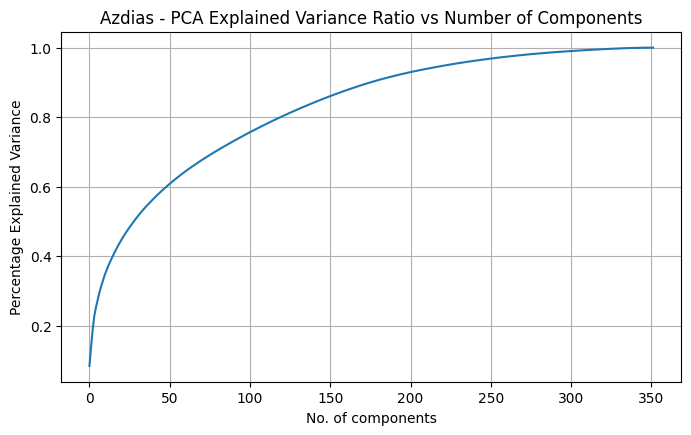

In [242]:
plot_pca_exp_variance(pca_azdias)

In [243]:
pca_150, azdias_pca_150 = perform_pca(azdias, n_components=150)


### 1.1.1 Interpreting PCA Components

In [244]:
def plot_feature_weights(df, pca, attributes_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

#### Component 0

In [245]:
diasAttr

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
...,...,...,...,...
2253,NaN,NaN,2,smart
2254,NaN,NaN,3,fair supplied
2255,NaN,NaN,4,price driven
2256,NaN,NaN,5,seeking orientation


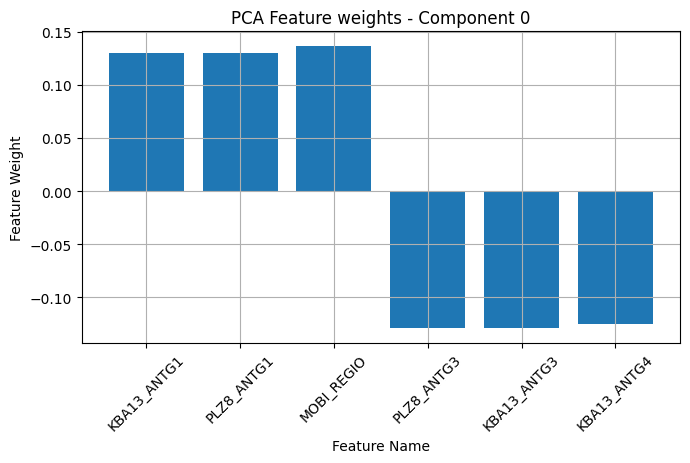

,Feature,Description,FeatureWeight
0,MOBI_REGIO,moving patterns,0.137053
1,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.130411
2,KBA13_ANTG1,No description given,0.129759
3,KBA13_ANTG4,No description given,-0.124765
4,KBA13_ANTG3,No description given,-0.128528
5,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.129237


In [246]:
component_0_info = plot_feature_weights(azdias, pca_azdias, diasAttr, 0, 3)
component_0_info.head(10)

#### Component 1

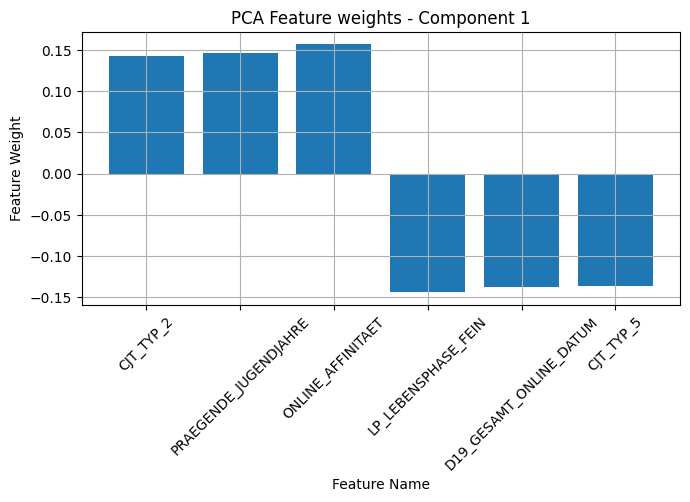

,Feature,Description,FeatureWeight
0,ONLINE_AFFINITAET,online affinity,0.156750
1,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),0.145748
2,CJT_TYP_2,No description given,0.142592
3,CJT_TYP_5,No description given,-0.136657
4,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the complete file ONLINE,-0.138195
5,LP_LEBENSPHASE_FEIN,lifestage fine,-0.143904


In [247]:
component_1_info = plot_feature_weights(azdias, pca_azdias, diasAttr, 1, 3)
component_1_info.head(10)

#### Component 2

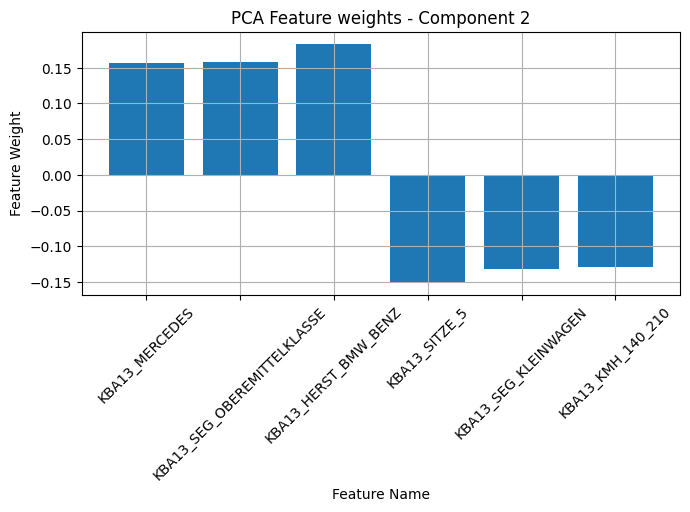

,Feature,Description,FeatureWeight
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.183271
1,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",0.158266
2,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.156829
3,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,-0.128896
4,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8",-0.131205
5,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.151114


In [248]:
component_2_info = plot_feature_weights(azdias, pca_azdias, diasAttr, 2, 3)
component_2_info.head(10)

#### Component 3 

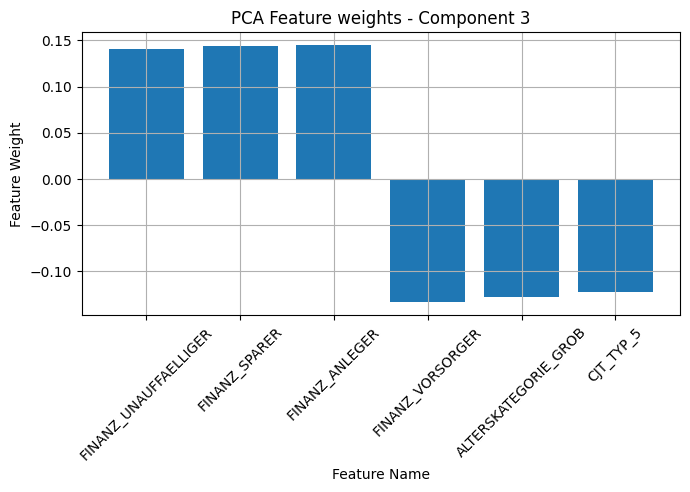

,Feature,Description,FeatureWeight
0,FINANZ_ANLEGER,financial typology: investor,0.144784
1,FINANZ_SPARER,financial typology: money saver,0.144219
2,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,0.140980
3,CJT_TYP_5,No description given,-0.121912
4,ALTERSKATEGORIE_GROB,age classification through prename analysis,-0.127511
5,FINANZ_VORSORGER,financial typology: be prepared,-0.133352


In [250]:
component_3_info = plot_feature_weights(azdias, pca_azdias, diasAttr, 3, 3)
component_3_info.head(10)

#### Component 4

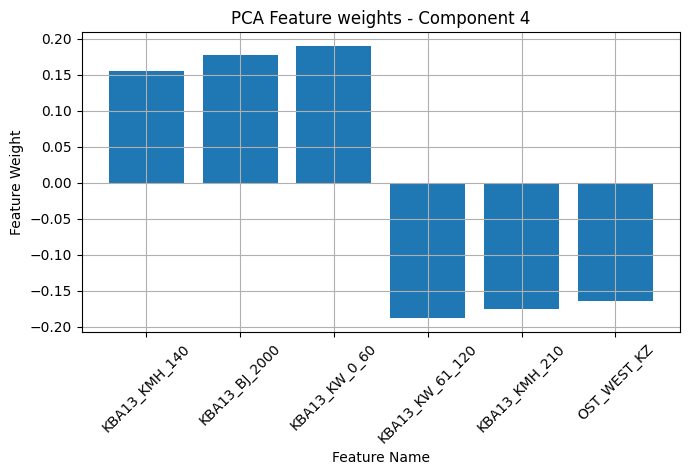

,Feature,Description,FeatureWeight
0,KBA13_KW_0_60,share of cars up to 60 KW engine power - PLZ8,0.190267
1,KBA13_BJ_2000,share of cars built between 2000 and 2003 within the PLZ8,0.177084
2,KBA13_KMH_140,share of cars with max speed between 110 km/h and 140km/h within the PLZ8,0.154800
3,OST_WEST_KZ,flag indicating the former GDR/FRG,-0.165051
4,KBA13_KMH_210,No description given,-0.175680
5,KBA13_KW_61_120,share of cars with an engine power between 61 and 120 KW - PLZ8,-0.188235


In [251]:
component_4_info = plot_feature_weights(azdias, pca_azdias, diasAttr, 4, 3)
component_4_info.head(10)

### 1.2 Customer Segmentation and K-Means Clustering

In [252]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [253]:
%%time
scores, range_ = get_Kmeans_scores(azdias_pca_150, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  207217752.3454135
Time elapsed: 1.09 sec.

Training for n_clusters:  3
Done! Score:  199499516.83079618
Time elapsed: 0.73 sec.

Training for n_clusters:  4
Done! Score:  195113065.83427545
Time elapsed: 1.29 sec.

Training for n_clusters:  5
Done! Score:  191555532.54899848
Time elapsed: 1.72 sec.

Training for n_clusters:  6
Done! Score:  188459107.31159174
Time elapsed: 1.58 sec.

Training for n_clusters:  7
Done! Score:  186035313.89611468
Time elapsed: 2.42 sec.

Training for n_clusters:  8
Done! Score:  183969967.89176017
Time elapsed: 1.57 sec.

Training for n_clusters:  9
Done! Score:  182508257.68107906
Time elapsed: 1.95 sec.

Training for n_clusters:  10
Done! Score:  180842750.83051914
Time elapsed: 2.22 sec.

Training for n_clusters:  11
Done! Score:  179666211.93616143
Time elapsed: 3.94 sec.

Training for n_clusters:  12
Done! Score:  178757689.81514677
Time elapsed

In [254]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

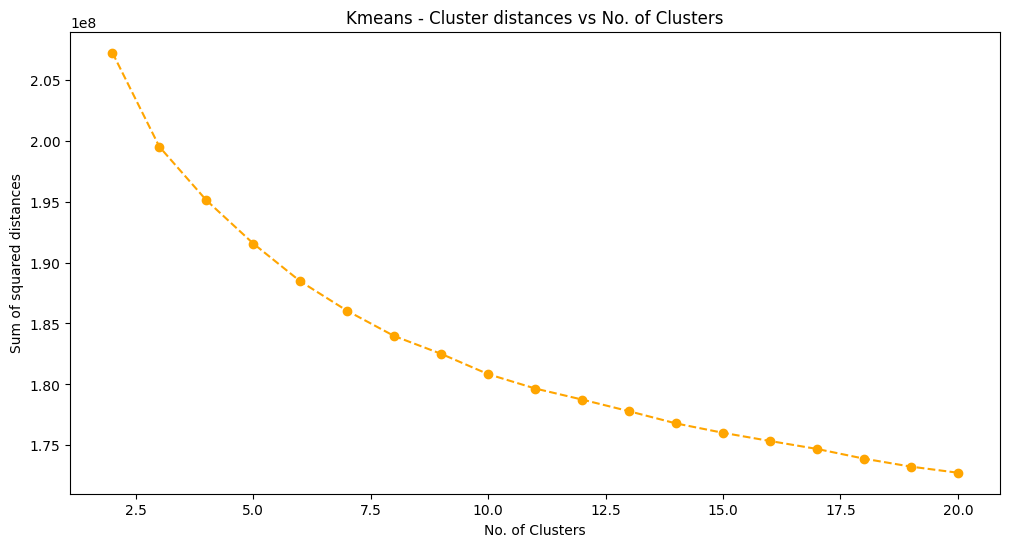

In [255]:
plot_elbow(scores, range_)

#### Choosing Number of Clusters

The primary concept behind clustering algorithms is to determine the optimal number of clusters by minimizing the variation within each cluster. While there isn’t a definitive approach for selecting the number of clusters, several direct and statistical methods exist. One widely-used method for this purpose is the elbow method.

The elbow method suggests that the ideal number of clusters is identified when adding an additional cluster no longer significantly reduces the variation within clusters. In other words, adding another cluster doesn’t notably lower the sum of squared distances between clusters.

In the example shown, the sum of squared errors drops sharply until around eight clusters, after which the slope becomes less steep, indicating the optimal point.

In [257]:
kmeans = KMeans(8, random_state=SEED)

kmeans.fit(azdias_pca_150)

KMeans(random_state=34)

In [258]:
azdias_clusters = kmeans.predict(azdias_pca_150)

In [259]:
customers_pca_150 = pca_150.transform(customers)

In [260]:
customers_clusters = kmeans.predict(customers_pca_150)

In [261]:
print(azdias_clusters[:15], "\n",customers_clusters[:15])

[5 5 2 1 2 5 5 4 4 3 5 5 4 0 5] 
 [2 3 2 1 4 6 4 3 6 6 6 3 4 6 6]


In [262]:
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [263]:
customers_clusters.value_counts().sort_index()

0     2258
1     4345
2    38329
3    16297
4    31918
5     1299
6    36504
7     3296
Name: count, dtype: int64

In [264]:
azdias_clusters.value_counts().sort_index()

0     89430
1     65074
2    116209
3     99184
4     71506
5    112921
6    115651
7     67313
Name: count, dtype: int64

#### Number of people in each cluster

In [265]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [266]:
cluster_info

,Cluster,Population,Customers
0,0,89430,2258
1,1,65074,4345
2,2,116209,38329
3,3,99184,16297
4,4,71506,31918
5,5,112921,1299
6,6,115651,36504
7,7,67313,3296


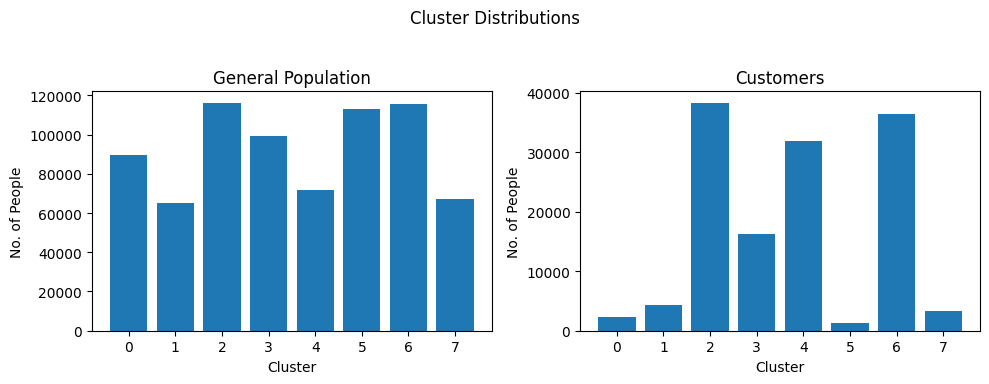

In [267]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### How much percentage of population under consideration is present in each cluster.


In [269]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

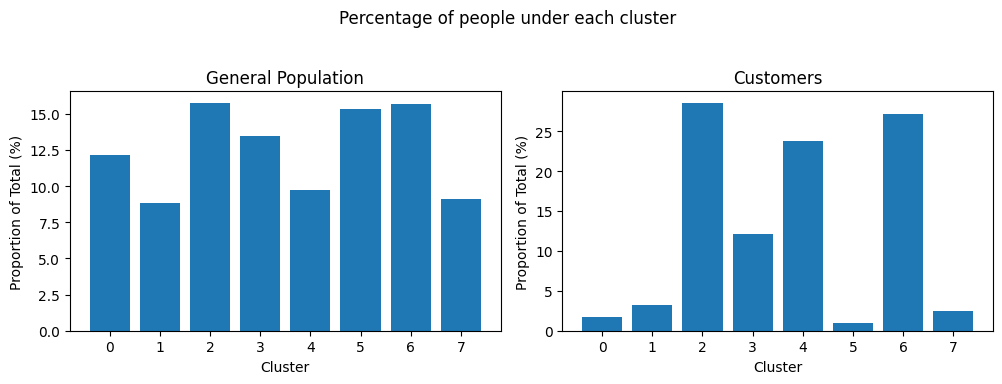

In [270]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Pop_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Cust_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Ratio of Proportion of Customers to Proportion of General Population in each cluster


The ratio of the customer proportion to the general population proportion in each cluster provides insight into which clusters the mail-order company's current customers belong to and where potential new customers might be found. For instance, if the ratio of the customer proportion to the population proportion in a particular cluster is greater than one, it indicates that there is a higher likelihood of attracting future customers from that cluster. This analysis helps identify clusters with a greater propensity for acquiring new customers.

In [271]:
cluster_info["Cust_over_Pop"] = cluster_info["Cust_proportion"] / cluster_info["Pop_proportion"]

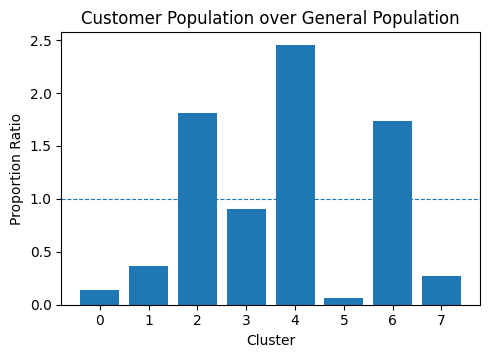

In [272]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(cluster_info["Cluster"], cluster_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


A ratio greater than 1 indicates that a cluster has a higher concentration of customers, suggesting potential for people in these clusters to become future customers. The ratio between customer and population proportions provides insights into the distribution of customers across different clusters. This information helps identify which clusters can be strategically targeted to acquire future customers.

#### What does each cluster represent ?

In [273]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=2, num_feat_per_comp=3):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True, ignore_index=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [278]:
cluster_2 = explain_cluster(kmeans, 2, azdias, pca_150, diasAttr)
cluster_2

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,3.671765,MOBI_REGIO,moving patterns,0.137053
1,0,3.671765,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.130411
2,0,3.671765,KBA13_ANTG1,No description given,0.129759
3,0,3.671765,KBA13_ANTG4,No description given,-0.124765
4,0,3.671765,KBA13_ANTG3,No description given,-0.128528
5,0,3.671765,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.129237
6,3,0.655633,FINANZ_ANLEGER,financial typology: investor,0.144784
7,3,0.655633,FINANZ_SPARER,financial typology: money saver,0.144219
8,3,0.655633,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,0.140980
9,3,0.655633,CJT_TYP_5,No description given,-0.121912


In [279]:
cluster_4 = explain_cluster(kmeans, 4, azdias, pca_150, diasAttr)
cluster_4

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,2,6.047255,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.183271
1,2,6.047255,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)",0.158266
2,2,6.047255,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.156829
3,2,6.047255,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8,-0.128896
4,2,6.047255,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8",-0.131205
5,2,6.047255,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.151114
6,0,2.002119,MOBI_REGIO,moving patterns,0.137053
7,0,2.002119,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.130411
8,0,2.002119,KBA13_ANTG1,No description given,0.129759
9,0,2.002119,KBA13_ANTG4,No description given,-0.124765


In [280]:
cluster_6 = explain_cluster(kmeans, 6, azdias, pca_150, diasAttr)
cluster_6

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,7.613881,MOBI_REGIO,moving patterns,0.137053
1,0,7.613881,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.130411
2,0,7.613881,KBA13_ANTG1,No description given,0.129759
3,0,7.613881,KBA13_ANTG4,No description given,-0.124765
4,0,7.613881,KBA13_ANTG3,No description given,-0.128528
5,0,7.613881,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.129237
6,1,3.443242,ONLINE_AFFINITAET,online affinity,0.156750
7,1,3.443242,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (avantgarde or mainstream),0.145748
8,1,3.443242,CJT_TYP_2,No description given,0.142592
9,1,3.443242,CJT_TYP_5,No description given,-0.136657


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [341]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = mailout_train.drop(columns=['Unnamed: 0'])


/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/3239851280.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [342]:
mailout_train.shape

(42962, 367)

In [343]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


RESPONSE
0    42430
1      532
Name: count, dtype: int64


<Axes: xlabel='RESPONSE', ylabel='count'>

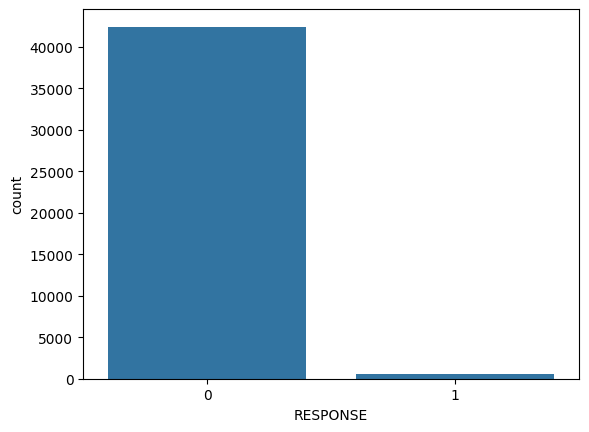

In [344]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot(x = "RESPONSE", data=mailout_train)

### 2.1 Selecting the Evaluation Metric

The dataset is highly imbalanced, with over 40,000 instances labeled as 0 and only 532 labeled as 1. Due to this imbalance, accuracy is not a suitable metric, as it could exceed 98% even if the model predicts all instances as zero. For instance, calculating 42430/(42430 + 532) * 100 results in an accuracy of 98.7%, which would be misleading in this scenario.

To address this imbalance in model evaluation, it is essential to select a metric that accounts for class imbalance. Commonly used metrics for imbalanced classification include Precision, Recall, or the Area Under the Receiver Operating Characteristic Curve (AUROC).

Before diving into these metrics, it is important to understand the basics of a confusion matrix. In binary classification, a confusion matrix is a 2x2 table that shows the number of correct and incorrect predictions. It forms the basis for calculating all classification metrics, including accuracy.

The confusion matrix consists of the following terms:
- **True Positives (TP)**: The number of actual positive cases predicted correctly.
- **True Negatives (TN)**: The number of actual negative cases predicted correctly.
- **False Negatives (FN)**: The number of actual positive cases predicted as negative.
- **False Positives (FP)**: The number of actual negative cases predicted as positive.

**Precision and Recall** are defined as:
- **Precision** = TP / (TP + FP)
- **Recall** = TP / (TP + FN)

**ROC Curve Metrics**:
- **True Positive Rate** = TP / (TP + FN)
- **False Positive Rate** = FP / (FP + TN)

From these formulas, we can see that Precision and Recall focus on the model's performance with respect to positive cases. These metrics are useful when the emphasis is on the positive class.

On the other hand, ROC metrics evaluate the model’s ability to distinguish between classes, considering both positive and negative predictions. This is why ROC-based metrics can be valuable for assessing overall model performance.

In this case, where the goal is to predict whether a person will potentially become a customer, the AUROC metric is a suitable choice. It considers both true positive and false positive rates, making it appropriate for situations where accurately predicting both classes is equally important.

### 2.2. Cleaning Data for Modelling

In [345]:
import time
import pandas as pd
from sklearn.impute import SimpleImputer

def clean_data_for_supervised(cleaned_azdias, df, attributes_values):
    """
    Cleans the given dataframe by performing several transformations and imputations.
    
    Parameters:
    cleaned_azdias (pd.DataFrame): The reference dataframe that contains cleaned data.
    df (pd.DataFrame): The dataframe to be cleaned.
    attributes_values (pd.DataFrame): The dataframe that holds attribute descriptions and meanings.
    
    Returns:
    pd.DataFrame: The cleaned dataframe.
    """
    
    print("Cleaning Given Dataframe")
    start = time.time()

    # Forward fill the 'Attribute' column to fill missing values with the last valid entry.
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()

    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])

    # Fix 'CAMEO' columns if not already cleaned
    if not (df[warning_cols[0]].dtype == 'float64') and not (df[warning_cols[1]].dtype == 'float64'):
        df = fix_cameo_cols(df)
        
    # Fixing LP_* columns
    print("\tFixing LP_* columns")
    df = fix_LP_cols(df)

    # Fixing EINGEFUGT column
    print("\tFixing EINGEFUGT column")
    df = fix_eigefugt_col(df)

    # Replacing "Unknown" values with NaN
    print("\tReplacing 'unknown' values with NaN")
    unknown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
    df = replace_unkowns(df, unknown_attributes_values, verbose=False)

    # Encoding OST_WEST_KZ column
    print("\tEncoding OST_WEST_KZ column")
    df = fix_ost_west_col(df)

    # Encoding ANREDE column
    print("\tEncoding ANREDE column")
    df = fix_anrede_col(df)

    # Encoding CAMEO_INT column
    print("\tEncoding CAMEO_INT column")
    df = fix_cameo_intl_col(df)

    # Encoding WOHNLAGE column
    print("\tEncoding WOHNLAGE column")
    df = fix_wohnlage_col(df)

    # Dropping columns not present in the cleaned azdias dataframe
    print("\tDropping extra columns")
    cols_to_drop = [col for col in df.columns if col not in cleaned_azdias.columns]
    df = remove_columns(df, cols_to_drop)

    # Imputing missing values with the most frequent ones
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")
    imputer.fit(cleaned_azdias)
    df = pd.DataFrame(imputer.transform(df), columns=df.columns)

    end = time.time()
    print(f"Completed Cleaning in {end - start:.2f} seconds")

    return df


In [346]:
labels = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

In [347]:
mailout_train = clean_data_for_supervised(azdias, mailout_train, diasAttr)


Cleaning Given Dataframe
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unknown' values with NaN
	Encoding OST_WEST_KZ column
	Encoding ANREDE column
	Encoding CAMEO_INT column
	Encoding WOHNLAGE column
	Dropping extra columns
	Imputing missing values with most frequent ones


/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/1930200809.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/2509986186.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/2509986186.py:4: Performan

Completed Cleaning in 3.82 seconds


In [348]:
mailout_train.shape

(42962, 352)

In [349]:
azdias.shape

(737288, 352)

### 2.3. Setting the benchmark

In [350]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [351]:
lr = LogisticRegression(random_state=SEED)

In [352]:
lr.fit(X_train, y_train)

/Users/demirhandemirkol/Desktop/capstone_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=34)

In [353]:
lr_pred = lr.predict_proba(X_val)[:,1]

In [354]:
lr_pred

array([0.01004385, 0.02535135, 0.01231828, ..., 0.00981395, 0.00823191,
       0.01274292])

In [355]:
print("Baseline AUROC - ", roc_auc_score(y_val, lr_pred))

Baseline AUROC -  0.6559199308153869


### 2.4. Trying different models

#### Scaling Data

In [356]:
scaler = StandardScaler()

mailout_train = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

In [357]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [358]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed 

In [359]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]

In [360]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

/Users/demirhandemirkol/Desktop/capstone_project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [361]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.681387,0.178834
1,DecisionTreeClassifier,0.508162,1.317225
2,RandomForestClassifier,0.615162,4.753091
3,GradientBoostingClassifier,0.781527,29.894687
4,AdaBoostClassifier,0.767949,6.397076
5,XGBClassifier,0.707988,0.509184


Based on the table, we can observe that the GradientBoostingClassifier achieves the highest AUC-ROC score, indicating strong performance. However, it also takes the longest time to train, which might not be ideal if training time is a critical factor.

XGBClassifier and AdaBoostClassifier have the next highest AUC-ROC scores. They strike a better balance between performance and training time, making them suitable candidates for further improvement through hyperparameter tuning.

Before diving into hyperparameter tuning, it’s a good idea to explore reducing the number of dimensions (features) in the dataset. This step could potentially improve model performance and speed up training time by eliminating irrelevant or redundant features. Feature reduction techniques, such as Principal Component Analysis (PCA) or feature selection methods, could be applied to achieve this.

In [362]:
mailout_train_reduced = pca_150.transform(mailout_train)

X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(mailout_train_reduced, labels,
                                                                  stratify=labels, test_size=0.2, random_state=SEED)

In [363]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]

results_reduced = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train_red, y_train_red, X_val_red, y_val_red)
    results_reduced["Model"].append(name)
    results_reduced["AUCROC_score"].append(roc)
    results_reduced["Time_in_sec"].append(time_)
    
results_reduced = pd.DataFrame.from_dict(results_reduced, orient='index').transpose()
results_reduced

/Users/demirhandemirkol/Desktop/capstone_project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.668526,0.06706
1,DecisionTreeClassifier,0.491965,16.697519
2,RandomForestClassifier,0.527348,50.05163
3,GradientBoostingClassifier,0.638994,106.885409
4,AdaBoostClassifier,0.587696,21.163044
5,XGBClassifier,0.601829,0.557964


Dimensionality reduction doesn't appear to be beneficial in this case. Therefore, we'll proceed with the complete set of columns in the dataset moving forward.

### 2.5. Grid Search

#### AdaBoostClassifier

In [364]:
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=SEED), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [365]:
%%time
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=50; total time=   6.1s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=50; total time=   6.1s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=50; total time=   6.1s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=50; total time=   6.1s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=50; total time=   6.2s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=100; total time=  12.0s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=100; total time=  12.1s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=100; total time=  12.1s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=100; total time=  12.2s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=100; total time=  12.3s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=50; total time=   6.1s
[CV] END algorithm=SAMME, learni

In [366]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7842


In [367]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})') 

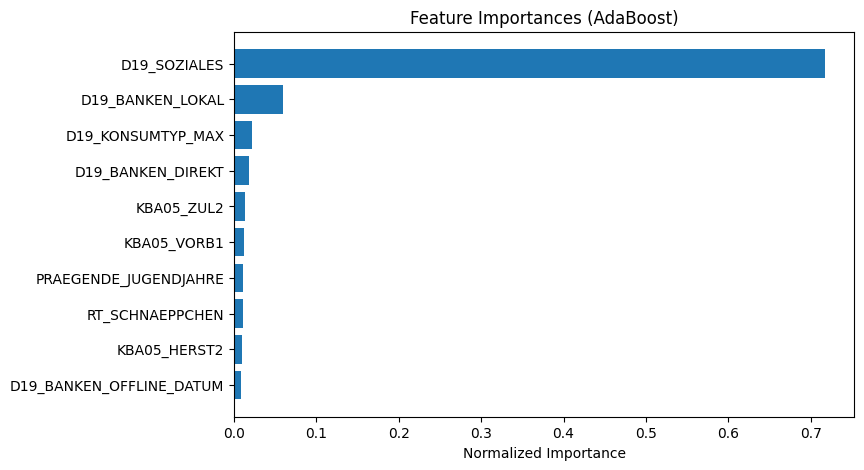

In [368]:
plot_feature_importances(model=best_adaboost, model_name="AdaBoost", feature_names=mailout_train.columns)

#### XGBClassifier

In [369]:
xgb_param_grid = {
    "max_depth": [5, 10, 20, 30],
    "learning_rate": [0.01, 0.1, 0.5, 0.9, 1.0],
    "gamma": [0.5, 1.0],
    "n_estimators": [50, 100, 200]
}

# Initialize GridSearchCV
xgb_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective="binary:logistic", 
        n_jobs=-1, 
        eval_metric="auc", 
        verbosity=0, 
        random_state=SEED
    ), 
    param_grid=xgb_param_grid, 
    scoring="roc_auc", 
    cv=5, 
    n_jobs=-1, 
    verbose=2
)

In [370]:
%%time
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.0s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.5s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.8s
[CV] END gamma=0.5, learning_rate=0.01, ma

/Users/demirhandemirkol/Desktop/capstone_project/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END gamma=0.5, learning_rate=0.01, max_depth=30, n_estimators=50; total time=   1.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=30, n_estimators=50; total time=   1.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=30, n_estimators=50; total time=   1.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=30, n_estimators=50; total time=   1.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=30, n_estimators=50; total time=   1.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=20, n_estimators=200; total time=   4.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=30, n_estimators=100; total time=   2.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=20, n_estimators=200; total time=   4.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=30, n_estimators=100; total time=   2.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=30, n_estimators=100; total time=   2.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=20, n_estimators=200; total time=   4.1s
[CV]

In [371]:
print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

Best Score:  0.7674040468669541
Best Params:  {'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


In [372]:
preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

ROC score on validation data: 0.7826


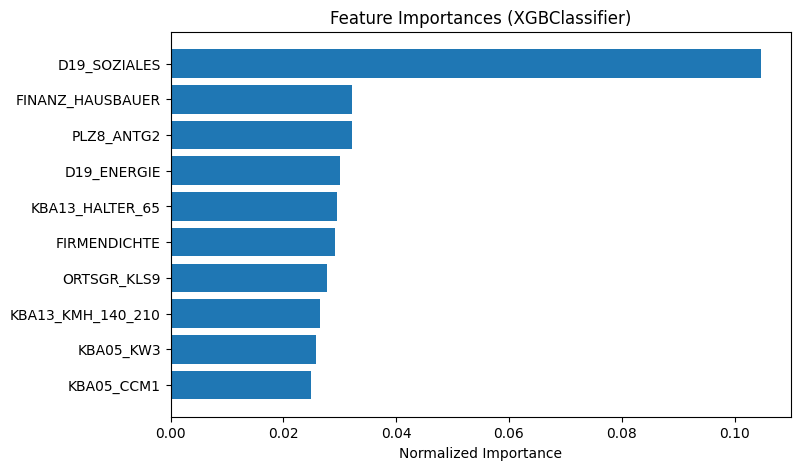

In [373]:
plot_feature_importances(model=best_xgb, model_name="XGBClassifier", feature_names=mailout_train.columns)

### 2.6 Justification


Based on the results of the models, here's the comparison and final selection:

- **Logistic Regression**: Baseline AUROC is **0.6559**. As a simple linear model, it didn’t capture the complexities of the dataset well enough. This resulted in moderate discrimination ability but isn't ideal for handling non-linear patterns or complex feature interactions.

- **AdaBoost**: AUROC on validation data is **0.7842**. This significant improvement shows that AdaBoost successfully captures more non-linear relationships in the data. By focusing on correcting misclassifications through multiple iterations, AdaBoost was able to outperform the baseline considerably.

- **XGBoost**: AUROC on validation data is **0.7826**. Similarly, XGBoost boosted the performance above the baseline. The algorithm’s ability to handle complex patterns and its efficiency with larger datasets make it a strong contender.

### Final Selection:
Both AdaBoost and XGBoost significantly outperform Logistic Regression, but AdaBoost slightly edges out XGBoost in terms of AUROC. Given the marginal difference, and unless there are specific requirements like large datasets or more tuning needs, **AdaBoost** would be my pick for its better ROC score and capability to handle non-linearities in the data effectively.

## Part 3: Kaggle Competition

In [374]:
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = mailout_test.drop(columns=['Unnamed: 0'])

/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/4186292507.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


### Cleaning Test Dataset

In [375]:
mailout_test

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,67615,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1
42829,67938,0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,2.0,...,4.0,10.0,9.0,6.0,6.0,9.0,3.0,3,1,4
42830,67942,-1,1.0,16.0,14.0,17.0,NaN,NaN,15.0,1.0,...,2.0,1.0,1.0,1.0,1.0,9.0,3.0,2,1,3
42831,67949,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,4.0,4.0,2.0,6.0,9.0,3.0,3,2,3


In [376]:
mailout_test_LNR = mailout_test["LNR"]
mailout_test = clean_data_for_supervised(azdias, mailout_test, diasAttr)
mailout_test = pd.DataFrame(scaler.transform(mailout_test), columns = mailout_test.columns)

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unknown' values with NaN
	Encoding OST_WEST_KZ column
	Encoding ANREDE column
	Encoding CAMEO_INT column
	Encoding WOHNLAGE column
	Dropping extra columns
	Imputing missing values with most frequent ones


/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/1930200809.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/2509986186.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
/var/folders/3b/lk1t0jzn5w33r2tdmghpft_00000gn/T/ipykernel_20040/2509986186.py:4: Performan

Completed Cleaning in 3.70 seconds


### Fitting the best models on complete train data and Making predictions on test data

#### AdaBoost


In [377]:
best_adaboost.fit(mailout_train, labels)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5, n_estimators=150,
                   random_state=34)

In [378]:
preds_test_adaboost = best_adaboost.predict_proba(mailout_test)[:,1]

In [379]:
kaggle_adaboost = pd.DataFrame(index=mailout_test_LNR, data=preds_test_adaboost)
kaggle_adaboost.rename(columns={0: "RESPONSE"}, inplace=True)

In [380]:
kaggle_adaboost.head()

,RESPONSE
LNR,
1754,0.331353
1770,0.324913
1465,0.234016
1470,0.232673
1478,0.222988


In [381]:
kaggle_adaboost.to_csv("./submission1.csv")


#### XGBoost

In [382]:
best_xgb.fit(mailout_train, labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=34, ...)

In [383]:
preds_test_xgb = best_xgb.predict_proba(mailout_test)[:,1]

In [384]:
kaggle_xgb = pd.DataFrame(index=mailout_test_LNR, data=preds_test_xgb)
kaggle_xgb.rename(columns={0: "RESPONSE"}, inplace=True)

In [385]:
kaggle_xgb.head()

,RESPONSE
LNR,
1754,0.066042
1770,0.063362
1465,0.047241
1470,0.047241
1478,0.047241


In [386]:
kaggle_xgb.to_csv("./submission2.csv")